In this directory I use astronomical images to train neural network. In this notebook I use the case of stars versus galaxies. That should be relatively simple, at least with sufficient signal to noise. 

This notebook user stricter criteria to better separate the classes.

In [1]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression


Now loading the data on the classification and other properties of the objects to be classified. 

In [2]:
df=pd.read_csv('Stripe82_1b.csv',sep=',')
print(df.columns)

Index(['objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'probPSF_u', 'probPSF_g', 'probPSF_r', 'probPSF_i',
       'probPSF_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'run', 'rerun',
       'camcol', 'field', 'type', 'specobjid', 'class', 'subclass', 'redshift',
       'zErr', 'zWarning', 'zErr_noqso', 'zWarning_noqso', 'z_noqso',
       'snMedian_r', 'snMedian_i', 'z_person', 'class_person', 'plate', 'mjd',
       'fiberid'],
      dtype='object')


Now looking on the classes, the targets and their counts. 

In [3]:
print(df['class'].value_counts())

GALAXY    3205
STAR      1735
QSO        355
Name: class, dtype: int64


Now I load an image and to do a first test display of the numeric data.

In [4]:
path='/home/tobias/ml-testing/astr-images/'
hbin=fits.open(path+'f2001_rdeep.fits.gz')
im1=hbin[0].data
#hbin.close()
print(im1)

[[-0.1769429   0.8691173   0.8408659  ... -1.000337   -0.7853276
  -0.45219374]
 [ 0.75963277 -0.4932522   1.3954576  ... -0.41785482 -1.3604484
  -0.5760638 ]
 [ 0.74020797  0.50546163  0.67057353 ...  0.37528276 -0.6279215
  -0.12317654]
 ...
 [ 0.8284947   0.14578946 -0.6937766  ...  1.4887718   2.2809432
   2.2037222 ]
 [ 0.9416072   0.7137203   0.43595394 ...  1.1946634   2.0303423
   2.3305871 ]
 [ 0.57620764 -0.2957804   0.5933519  ...  0.98817205  1.3469133
   2.5567775 ]]


I now built a function which gets the area mcovers by an image. That is used later to find the right image for the targets.

In [5]:
def image_area(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    image=dat[0].data
    res=np.array([[ra_ref+(1-ra_center)*ra_scale,ra_ref+(image.shape[0]-ra_center)*ra_scale],[dec_ref+(1-dec_center)*dec_scale,dec_ref+(image.shape[1]-dec_center)*dec_scale]])
    return res

Similiarly the function image_par gets the coordinate parameter of an image for this data set.

In [6]:
#assumes that the image pixel coordiantes are perfectly aligned with the skyb coordiates ra and dec
#that is true for this data set but in general another two parameters are needed to specify the miss alignment
def image_par(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    par=np.array([ra_ref,ra_center,ra_scale,dec_ref,dec_center,dec_scale])
    return par

Below I build a function which gets the image position of an object whose sky position is known. 
The information on the image can be either obtained from an image or from the opreviously collected image coordinate parameters.

In [8]:
#ra dec position coordinate of object, dat is image inpt, not zero if image==True,
# par is parameter inpu not yero if image==False
def image_xy(ra,dec,dat=0,par=0,image=True):
    #image is used input and the parameters are used
    if image==True:
        ra_ref=dat[0].header['CRVAL1']
        ra_center=dat[0].header['CRPIX1']
        ra_scale=dat[0].header['CD1_1']
        dec_ref=dat[0].header['CRVAL2']
        dec_center=dat[0].header['CRPIX2']
        dec_scale=dat[0].header['CD2_2'] 
    #paramter input    
    else:   
        ra_ref=par[0]
        ra_center=par[1]
        ra_scale=par[2]
        dec_ref=par[3]
        dec_center=par[4]
        dec_scale=par[5]
    #get the positions (pixels on image) 
    # the cosine part is only important if the image not close to the euqator 
    x=ra_center+(ra-ra_ref)/ra_scale*np.cos(dec/180*np.pi)
    y=dec_center+(dec-dec_ref)/dec_scale
    pixels=np.array([x,y])
    return pixels

Now getting all images in a list. 

In [9]:
list_input_files=[f for f in os.listdir(path) 
    if f.endswith('_rdeep.fits.gz') and os.path.isfile(os.path.join(path, f))]
list_input_files.sort()
print(list_input_files)

['f2001_rdeep.fits.gz', 'f2002_rdeep.fits.gz', 'f2003_rdeep.fits.gz', 'f2004_rdeep.fits.gz', 'f2005_rdeep.fits.gz', 'f2011_rdeep.fits.gz', 'f2012_rdeep.fits.gz', 'f2013_rdeep.fits.gz', 'f2014_rdeep.fits.gz', 'f2015_rdeep.fits.gz', 'f2021_rdeep.fits.gz', 'f2022_rdeep.fits.gz', 'f2023_rdeep.fits.gz', 'f2024_rdeep.fits.gz', 'f2025_rdeep.fits.gz', 'f2031_rdeep.fits.gz', 'f2032_rdeep.fits.gz', 'f2033_rdeep.fits.gz', 'f2034_rdeep.fits.gz', 'f2035_rdeep.fits.gz', 'f2041_rdeep.fits.gz', 'f2042_rdeep.fits.gz', 'f2043_rdeep.fits.gz', 'f2044_rdeep.fits.gz', 'f2045_rdeep.fits.gz', 'f2051_rdeep.fits.gz', 'f2052_rdeep.fits.gz', 'f2053_rdeep.fits.gz', 'f2054_rdeep.fits.gz', 'f2055_rdeep.fits.gz', 'f2061_rdeep.fits.gz', 'f2062_rdeep.fits.gz', 'f2063_rdeep.fits.gz', 'f2064_rdeep.fits.gz', 'f2065_rdeep.fits.gz']


Now I get the centers and image parameters for all images.

In [10]:
centers=np.zeros((2,len(list_input_files)))
wcs_par=np.zeros((6,len(list_input_files)))
for i in range(len(list_input_files)):
    print(i)
    #get images
    hbin=fits.open(path+list_input_files[i],memmap=True)
    #get parameters wanted 
    res=image_area(hbin)
    par=image_par(hbin)
    hbin.close()
    centers[0,i]=(res[0,0]+res[0,1])/2  #center is avarage of extension in both dimensions
    centers[1,i]=(res[1,0]+res[1,1])/2
    #parameters to find objects on images
    wcs_par[:,i]=par
print(centers)    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
[[ 4.97500000e+01  4.97500000e+01  4.97500000e+01  4.97500000e+01
   4.97500000e+01  5.02500000e+01  5.02500000e+01  5.02500000e+01
   5.02500000e+01  5.02500000e+01  5.07500000e+01  5.07500000e+01
   5.07500000e+01  5.07500000e+01  5.07500000e+01  5.12500000e+01
   5.12500000e+01  5.12500000e+01  5.12500000e+01  5.12500000e+01
   5.17500000e+01  5.17500000e+01  5.17500000e+01  5.17500000e+01
   5.17500000e+01  5.22500000e+01  5.22500000e+01  5.22500000e+01
   5.22500000e+01  5.22500000e+01  5.27500000e+01  5.27500000e+01
   5.27500000e+01  5.27500000e+01  5.27500000e+01]
 [-1.00000000e+00 -5.00000000e-01 -1.08246745e-15  5.00000000e-01
   1.00000000e+00 -1.00000000e+00 -5.00000000e-01 -1.08246745e-15
   5.00000000e-01  1.00000000e+00 -1.00000000e+00 -5.00000000e-01
  -1.08246745e-15  5.00000000e-01  1.00000000e+00 -1.00000000e+00
  -5.00000000e-01 -1.08246745e-15  5.00000000e-01  1.00000000e

Now I am getting closest image and the pixels positions on them for all objects of the data frame. Further I create a binary classifier based on whether a galaxy or not to start with a  simple binary classification case. 

Here I am concervative, I exclude QSO which are mostly star like but not to 100%. I also require in addition that the shape classifiocation (star like or not) agrees with the spectral classifier.

In [11]:
df['galaxy'] = np.where(df['class']== 'GALAXY', True, False)
#Also I add dummy columns which are later filter with the image and the pixels positions on it for all onbjects
df['image']=-1
df['pixel_x']=-1.0
df['pixel_y']=-1.0
print(df.galaxy.value_counts())
#mark bad ones, exclude qso
df['bad'] = False
for i in range(df.shape[0]):
    if df['class'].iat[i]=='QSO':
        df.bad.iat[i]=True
    elif  df['class'].iat[i]=='GALAXY' and (df.probPSF_g.iat[i]==1 or df.probPSF_r.iat[i]==1 or df.probPSF_i.iat[i]==1):
        df.bad.iat[i]=True
    elif  df['class'].iat[i]=='STAR' and (df.probPSF_g.iat[i]==0 or df.probPSF_r.iat[i]==0 or df.probPSF_i.iat[i]==0):
        df.bad.iat[i]=True        
print(df.bad.value_counts())

True     3205
False    2090
Name: galaxy, dtype: int64
False    4722
True      573
Name: bad, dtype: int64


Below I go over all objects, find the closest image and get then the pixel position of the object.. 

In [13]:
for i in range(df.shape[0]):
    #distances to all images ceneters
    r=np.sqrt((df['ra'][i]-centers[0])**2+(df['dec'][i]-centers[1])**2)
    #id of the image
    df['image'].iloc[i]=np.argmin(r)
    #get pixel coordinates of image 
    coor=image_xy(df['ra'][i],df['dec'][i],par=wcs_par[:,df['image'].iloc[i]],image=False)
    df['pixel_x'].iloc[i]=coor[0]
    df['pixel_y'].iloc[i]=coor[1]
    

/tmp/ipykernel_4316/3953301984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'].iloc[i]=np.argmin(r)
/tmp/ipykernel_4316/3953301984.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_x'].iloc[i]=coor[0]
/tmp/ipykernel_4316/3953301984.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pixel_y'].iloc[i]=coor[1]


Analyse the new columns content. 

In [15]:
#sorted by value to see which iamges are used
print(df.image.value_counts().sort_index(0))
print(df.pixel_x.describe())
print(df.pixel_y.describe())

5     227
6     181
7     231
8     244
9     190
10    154
11    192
12    245
13    257
14    227
15    149
16    167
17    203
18    153
19    168
20    173
21    238
22    199
23    199
24    195
25    247
26    277
27    279
28    261
29    239
Name: image, dtype: int64
count    5295.000000
mean     2297.375179
std      1304.735601
min         4.991131
25%      1179.141102
50%      2323.782704
75%      3418.760954
max      4549.603869
Name: pixel_x, dtype: float64
count    5295.000000
mean     2253.338893
std      1304.361251
min       -70.538413
25%      1145.468620
50%      2213.411517
75%      3379.435823
max      4637.182527
Name: pixel_y, dtype: float64


/tmp/ipykernel_4316/1114175374.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  print(df.image.value_counts().sort_index(0))


I now sort the row of the data frame by image, that minizie how often the images need to be loaded. 

In [16]:
df=df.sort_values(by='image')
#reset index since the previous row is not wanted 
df=df.reset_index()
print(df.head)

<bound method NDFrame.head of       index                objid         ra       dec  psfMag_u  psfMag_g  \
0      3582  1237663237128388950  50.162303 -1.235258  22.56924  20.53544   
1      3630  1237666299481686305  50.002163 -0.867332  24.46523  21.17397   
2      3631  1237666299481751635  50.090055 -1.048266  19.01876  17.18463   
3      3632  1237666299481751800  50.009985 -0.929502  24.62791  20.55204   
4      3633  1237666299481751975  50.071922 -1.027052  21.75187  21.11250   
...     ...                  ...        ...       ...       ...       ...   
5290   4986  1237666302167089616  52.345132  1.118150  23.89564  22.45461   
5291   4985  1237666302167089405  52.259900  1.202159  23.45212  22.66528   
5292   4984  1237666302167089358  52.356925  1.077842  21.11749  20.82195   
5293   1058  1237660241925177639  52.107396  0.967077  22.52552  20.91562   
5294   3259  1237660241925243084  52.188624  0.867991  21.24787  18.69862   

      psfMag_r  psfMag_i  psfMag_z  probPSF_u

Now the arrays with the images are collected. For now I collect 11 times 11 pixels. The number is odd because it is usually centered on the brightest image. 

In [17]:
delta=5
#collected array
cut_outs=np.zeros((2*delta+1,2*delta+1,df.shape[0]))
#parameter to indicate whether an image exist. 
df['off_image']=False
for i in range(df.shape[0]):
    #image loaded if first image
    if i==0:
        #load file
        hbin=fits.open(path+list_input_files[df.image.iloc[i]])
        #get image, need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
        image=hbin[0].data.T
    else:
        #or if new image
        if df.image.iloc[i]!=df.image.iloc[i-1]:
            hbin=fits.open(path+list_input_files[df.image.iloc[i]])
            #need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
            image=hbin[0].data.T  
    #gfigure out if within image borders  then cut out image is collected       
    if round(df.pixel_x.iloc[i])>delta and round(df.pixel_x.iloc[i])<image.shape[0]-delta and  round(df.pixel_y.iloc[i])>delta and round(df.pixel_y.iloc[i])<image.shape[1]-delta:
        cut_outs[:,:,i]=image[round(df.pixel_x.iloc[i])-delta:round(df.pixel_x.iloc[i])+delta+1,round(df.pixel_y.iloc[i])-delta:round(df.pixel_y.iloc[i])+delta+1]
    else:
        #if not marker column set to true
        print(f"row {i} is off the image")
        df['off_image'].iloc[i]=True

row 74 is off the image
row 75 is off the image
row 105 is off the image


/tmp/ipykernel_4316/4177535269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['off_image'].iloc[i]=True


row 908 is off the image
row 1011 is off the image
row 1046 is off the image
row 1052 is off the image
row 1060 is off the image
row 1347 is off the image
row 1921 is off the image
row 2030 is off the image
row 2245 is off the image
row 2604 is off the image
row 2847 is off the image
row 2894 is off the image
row 2910 is off the image
row 2915 is off the image
row 2923 is off the image
row 3015 is off the image
row 3016 is off the image
row 3114 is off the image
row 3787 is off the image
row 3889 is off the image
row 3918 is off the image
row 3955 is off the image
row 3977 is off the image
row 4022 is off the image
row 4237 is off the image
row 4616 is off the image
row 4940 is off the image
row 5062 is off the image
row 5193 is off the image
row 5250 is off the image
row 5257 is off the image
row 5262 is off the image
row 5271 is off the image


Now I check how many rows are off the images.

In [18]:
print(df.off_image.value_counts())

False    5259
True       36
Name: off_image, dtype: int64


Not many, thus they can be ignore. Now  display one object of each kind. 

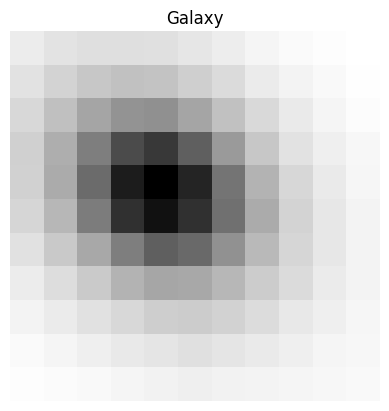

In [19]:
plt.axis('off')
plt.title("Galaxy")
plt.imshow(1-cut_outs[:,:,0].T,cmap=cm.gray, interpolation='nearest')

In [22]:
#finding star and galaxies for display
fs=df['class'][df['class']=='STAR']
print(fs)

1       STAR
2       STAR
3       STAR
5       STAR
6       STAR
        ... 
5286    STAR
5287    STAR
5288    STAR
5289    STAR
5294    STAR
Name: class, Length: 1735, dtype: object


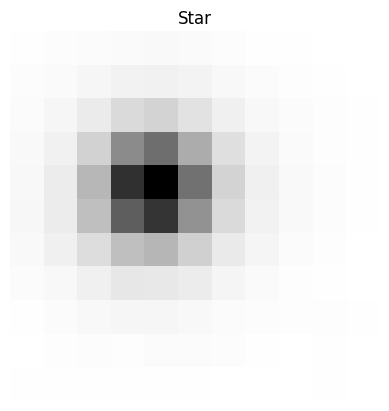

In [23]:
plt.axis('off')
plt.title("Star")
plt.imshow(1-cut_outs[:,:,fs.index[0]].T,cmap=cm.gray, interpolation='nearest')

As it should be the galaxy is less concentrated than the star. It is also visisble that the object are not fully isolated as often the case for images. 

I now drop the objects for which no image could have been found. I also add a forth dimension to the iamge array as needed by pytorch. 
I also exclude now the QSOs and the other objects which have potentially bad classifications. 

Because of the relevant noise on astronomical images I do not rescale the cut out images, since rescaling makes that noise is level is very different between different images, while it should be rather similar in this data set.    

In [24]:
#new data frame omitting the object where no image could be found  and laso bad ones
df2=df[(df.off_image==False) & (df.bad==False)]
print(df2.shape)
#new image array, to which also a 4 dimension of zero size is added 
cut_outs2=np.zeros((2*delta+1,2*delta+1,1,df2.shape[0]))
counter=0
for i in range(df.shape[0]):
    if df.off_image.iloc[i]==False and df.bad.iloc[i]==False:
        #adding the cut outs not of image
        cut_outs2[:,:,0,counter]=cut_outs[:,:,i]
        counter+=1
#Now I add the iamge value to the data frame, that can be used for all connected percitron networks 
x=0
for i in range(cut_outs2.shape[0]):
    for j in range(cut_outs2.shape[1]):
        df2[x]=cut_outs2[i,j,0,:]
        x+=1

(4691, 49)


/tmp/ipykernel_4316/1160719888.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_4316/1160719888.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[x]=cut_outs2[i,j,0,:]
/tmp/ipykernel_4316/1160719888.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [ ]:
Saving the tables that they can used later with more data from other fields. 

In [117]:
np.save("stripe82_1_small_im.npy",cut_outs2)    
df2.to_csv('stripe82_1_small_table.csv') 

Now the data is mostly prepared besides some libraries specifices. 



First I do basic setup tasks relevant for for all torch networks. For now that these are two, firstly a fully connected multilayer network as perceptron. Secondly, a network which uses twodiemnsionalk convolutional layer whoch should be optimized for images. 

First adding the cpu. 

In [25]:
#adding cpu
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [26]:
#need to be transposed to get into torch format of batch, channels, x, y
#splitting, feature_mlp, targets, feature_images, df properties
feature_train,feature_test,target_train, target_test,image_train,image_test,df_train,df_test= train_test_split(df2.loc[:,0:120],df2.loc[:,"galaxy"],cut_outs2.T,df2,train_size=0.70, shuffle=True, random_state=1)
print("shape of image train data")
print(image_train.shape)

shape of image train data
(3283, 1, 11, 11)


Now I change the target data type to numpy array where that is not yet the case. 

In [27]:
 
feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
print(type(target_train),type(image_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Now I create a class which creates the classification data sets as needed for torch. 

In [28]:
class ClassificationDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

Now I create the data sets as needed for both neural network types. 

In [29]:
train_dataset = ClassificationDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = ClassificationDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
train_im_dataset = ClassificationDataset(torch.from_numpy(image_train).float(), torch.from_numpy(target_train).float())
test_im_dataset = ClassificationDataset(torch.from_numpy(image_test).float(), torch.from_numpy(target_test).float())
#print type as test 
print(type(torch.from_numpy(image_test).float()))
print(type(test_im_dataset))


<class 'torch.Tensor'>
<class '__main__.ClassificationDataset'>


Now create the class of the perceptron layer. 

In [30]:
#now 3 layers 
#two options only 
class BinaryClassification3(nn.Module):
    def __init__(self, num_features):
        super(BinaryClassification3, self).__init__()
        self.fc1 = nn.Linear(num_features, 60)
        self.fc2 = nn.Linear(60, 20)  
        self.fc3 = nn.Linear(20, 8)        
        self.fc4 = nn.Linear(8, 1)   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return (x)

Now I define the parameters needed. 

In [31]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = 121
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_pred = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Finally I define the model plus the final parameters. 

In [32]:
model =BinaryClassification3(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#in loss_stats the statistic is collected 
loss_stats = {
    'train': [], 'test': []
}


BinaryClassification3(
  (fc1): Linear(in_features=121, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


Now I run the fit. 

In [33]:

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.23609 | Test Loss: 0.42427
Epoch 002: | Train Loss: 0.38099 | Test Loss: 0.41991
Epoch 003: | Train Loss: 0.35316 | Test Loss: 0.44253
Epoch 004: | Train Loss: 0.21858 | Test Loss: 0.41619
Epoch 005: | Train Loss: 0.18259 | Test Loss: 0.49750
Epoch 006: | Train Loss: 0.29290 | Test Loss: 0.41509
Epoch 007: | Train Loss: 0.20498 | Test Loss: 0.40667
Epoch 008: | Train Loss: 0.17376 | Test Loss: 0.31808
Epoch 009: | Train Loss: 0.11885 | Test Loss: 0.24544
Epoch 010: | Train Loss: 0.10604 | Test Loss: 0.31658
Epoch 011: | Train Loss: 0.10628 | Test Loss: 0.24649
Epoch 012: | Train Loss: 0.10248 | Test Loss: 0.24460
Epoch 013: | Train Loss: 0.08239 | Test Loss: 0.30906
Epoch 014: | Train Loss: 0.07545 | Test Loss: 0.11684
Epoch 015: | Train Loss: 0.11140 | Test Loss: 0.11307
Epoch 016: | Train Loss: 0.07915 | Test Loss: 0.11132
Epoch 017: | Train Loss: 0.07319 | Test Loss: 0.19261
Epoch 018: | Train Loss: 0.07506 | Test Loss: 0.24563
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.08515 | Test Loss: 0.16539
Epoch 154: | Train Loss: 0.03647 | Test Loss: 0.03224
Epoch 155: | Train Loss: 0.03235 | Test Loss: 0.09639
Epoch 156: | Train Loss: 0.03182 | Test Loss: 0.09920
Epoch 157: | Train Loss: 0.03161 | Test Loss: 0.10522
Epoch 158: | Train Loss: 0.03268 | Test Loss: 0.10262
Epoch 159: | Train Loss: 0.03140 | Test Loss: 0.10804
Epoch 160: | Train Loss: 0.03140 | Test Loss: 0.16990
Epoch 161: | Train Loss: 0.03127 | Test Loss: 0.17258
Epoch 162: | Train Loss: 0.03118 | Test Loss: 0.22910
Epoch 163: | Train Loss: 0.03114 | Test Loss: 0.23088
Epoch 164: | Train Loss: 0.03104 | Test Loss: 0.10411
Epoch 165: | Train Loss: 0.03111 | Test Loss: 0.23217
Epoch 166: | Train Loss: 0.03102 | Test Loss: 0.10746
Epoch 167: | Train Loss: 0.03094 | Test Loss: 0.23343
Epoch 168: | Train Loss: 0.03519 | Test Loss: 0.33853
Epoch 169: | Train Loss: 0.07334 | Test Loss: 0.09066
Epoch 170: | Train Loss: 0.03390 | Test Loss: 0.09180
Epoch 171: | Train Loss: 0.0

Now I define a function which predicts the values (probablities) for all samples. 

In [34]:
def pred_torch(model,data):
    y_pred_list_c = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in data:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_list_c.append(y_test_pred.cpu().numpy())
    y_pred_list_c = [a.squeeze().tolist() for a in y_pred_list_c]
    return y_pred_list_c  

That is then applied on all data. 

In [35]:
m_test=pred_torch(model,test_loader)
m_train=pred_torch(model,train_loader_pred)

I now plot the loss against the epoch. 

Text(0, 0.5, 'BCE loss')

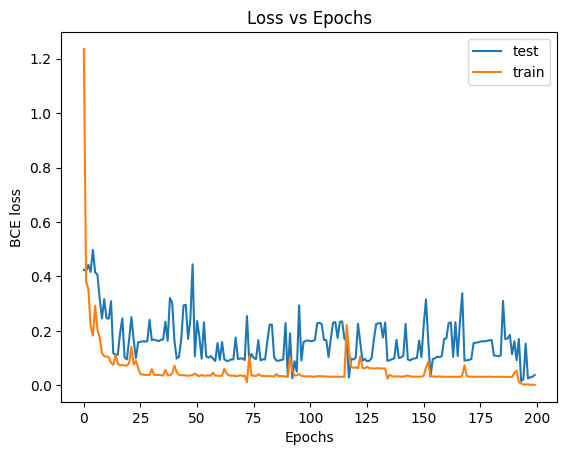

In [36]:

plt.plot(loss_stats['test'],label='test')
plt.plot(loss_stats['train'],label='train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')

There is likely overfitting, at least the loss of test improves less at the end.

Now I am building a first convolutional network. First loading the data again.  

In [37]:
train_im_loader = DataLoader(dataset=train_im_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_im_loader = DataLoader(dataset=test_im_dataset, batch_size=1)
train_im_loader_pred = DataLoader(dataset=train_im_dataset, batch_size=1)

Now I build the network. 

In [38]:
class CNNBinary3(torch.nn.Module):
    #no padding because image does not really end when the data ends. 
    def __init__(self):
        super(CNNBinary3, self).__init__()
        # L1 ImgIn shape=(?, 11, 11, 1)
        # Conv -> (?, 9, 9, 12)
        # Pool -> (?, 4, 4, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 4, 4, 32)
        # Conv      ->(?, 2, 2, 32)
        # Pool      ->(?, 1, 1, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 FC 1x1x32 inputs -> 16 outputs
        self.fc1 = torch.nn.Linear(1 * 1 * 32, 64, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer3 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L4 Final FC 64 inputs -> 1 output
        self.fc2 = torch.nn.Linear(64, 1, bias=True) #
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = torch.sigmoid(self.fc2(out))
        return out

Define the model. 

In [42]:
keep_prob=1
model2 =CNNBinary3()
model2.to(device)
print(model2)

CNNBinary3(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


In [43]:
#define the function to fit it
#parameters: model used, train_data, test_data, epchs, batch_size, learning_rate, file to collect sats, 
#optional regularization 
def torch_fit(model,train_loader,test_loader,epochs,batch_size,learning_rate,loss_stats,l2reg=0):
    learning_rate = learning_rate
    criterion = torch.nn.BCELoss()    # Softmax is internally computed.
    #if no regularization
    if l2reg==0:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    #l2 regularization is added in optimizer as weight_decay=1e-5 or nsimilar 
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate,weight_decay=l2reg)        
    print("Begin training.")
    for e in tqdm(range(1, epochs+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
        
            y_train_pred = model(X_train_batch)
        
            train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer.step()
        
            train_epoch_loss += train_loss.item()
        
        
        # VALIDATION    
        with torch.no_grad():
        
            test_epoch_loss = 0
        
            model.eval()
            for X_test_batch, y_test_batch in test_loader:
                X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
                y_test_pred = model(X_test_batch)
                        
                test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
                test_epoch_loss += test_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['test'].append(test_epoch_loss/len(test_loader))                              
    
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')    

Now define the array for data collection and then fit the data. 

In [44]:
#something here wrong but only here, regularized below works 
loss_stats_test = {
    'train': [], 'test': []
}
torch_fit(model2,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.98189 | Test Loss: 0.04814
Epoch 002: | Train Loss: 0.33386 | Test Loss: 0.09734
Epoch 003: | Train Loss: 0.16366 | Test Loss: 0.22778
Epoch 004: | Train Loss: 0.29409 | Test Loss: 0.09325
Epoch 005: | Train Loss: 0.07408 | Test Loss: 0.09980
Epoch 006: | Train Loss: 0.04472 | Test Loss: 0.09846
Epoch 007: | Train Loss: 0.04369 | Test Loss: 0.09768
Epoch 008: | Train Loss: 0.04151 | Test Loss: 0.10412
Epoch 009: | Train Loss: 0.01289 | Test Loss: 0.09208
Epoch 010: | Train Loss: 0.04217 | Test Loss: 0.17402
Epoch 011: | Train Loss: 0.11325 | Test Loss: 1.87759
Epoch 012: | Train Loss: 0.11862 | Test Loss: 0.15843
Epoch 013: | Train Loss: 0.07111 | Test Loss: 0.15856
Epoch 014: | Train Loss: 0.01291 | Test Loss: 0.03463
Epoch 015: | Train Loss: 0.01164 | Test Loss: 0.09456
Epoch 016: | Train Loss: 0.00807 | Test Loss: 0.09017
Epoch 017: | Train Loss: 0.01226 | Test Loss: 0.08952
Epoch 018: | Train Loss: 0.00694 | Test Loss: 0.08891
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00003 | Test Loss: 0.10311
Epoch 154: | Train Loss: 0.00003 | Test Loss: 0.04716
Epoch 155: | Train Loss: 0.00003 | Test Loss: 0.10515
Epoch 156: | Train Loss: 0.00003 | Test Loss: 0.10251
Epoch 157: | Train Loss: 0.00002 | Test Loss: 0.10614
Epoch 158: | Train Loss: 0.00002 | Test Loss: 0.10371
Epoch 159: | Train Loss: 0.00002 | Test Loss: 0.10477
Epoch 160: | Train Loss: 0.00002 | Test Loss: 0.10265
Epoch 161: | Train Loss: 0.00002 | Test Loss: 0.10495
Epoch 162: | Train Loss: 0.00002 | Test Loss: 0.10440
Epoch 163: | Train Loss: 0.00002 | Test Loss: 0.10427
Epoch 164: | Train Loss: 0.00001 | Test Loss: 0.10520
Epoch 165: | Train Loss: 0.00001 | Test Loss: 0.10092
Epoch 166: | Train Loss: 0.00001 | Test Loss: 0.10571
Epoch 167: | Train Loss: 0.00001 | Test Loss: 0.10200
Epoch 168: | Train Loss: 0.00001 | Test Loss: 0.10628
Epoch 169: | Train Loss: 0.00001 | Test Loss: 0.10525
Epoch 170: | Train Loss: 0.00001 | Test Loss: 0.10478
Epoch 171: | Train Loss: 0.0

Below I plot both neural network results. 

(0.0, 2.0)

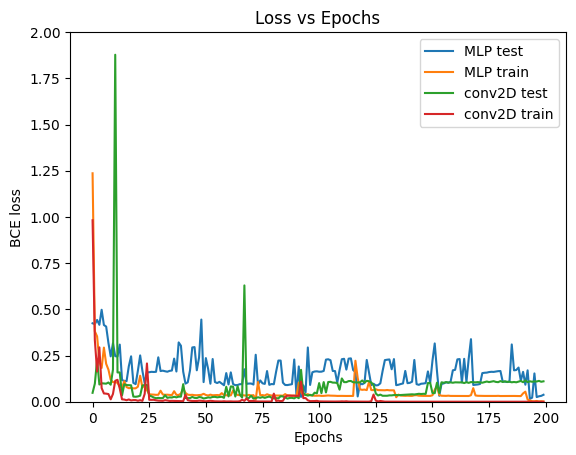

In [46]:
plt.plot(loss_stats['test'],label='MLP test')
plt.plot(loss_stats['train'],label='MLP train')
plt.plot(loss_stats_test['test'],label='conv2D test')
plt.plot(loss_stats_test['train'],label='conv2D train')
plt.legend(loc="best")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BCE loss')
plt.ylim(0,2)

Convolutional looks better, less overfitting, but it also not look perfect and the final loss is not  the best one. There are wiggles in test seem like that there is overfitting also there. Results change every fit slightly. 

Now I do some other algorithms with standard settings. First xgboost. 

In [47]:
xc1=XGBClassifier(max_depth=6).fit(feature_train,target_train)

Now predicting the results and getting the confusing matrixes. 

In [48]:
train_pred=xc1.predict(feature_train)
test_pred=xc1.predict(feature_test)
train_pred_prob=xc1.predict_proba(feature_train)
test_pred_prob=xc1.predict_proba(feature_test)
conf_train = confusion_matrix(target_train, train_pred)
conf_test = confusion_matrix(target_test, test_pred)
print("confusion matrix xgboost train")
print(conf_train)
print("confusion matrix xgboost test")
print(conf_test)

confusion matrix xgboost train
[[1115    0]
 [   0 2168]]
confusion matrix xgboost test
[[478   6]
 [  6 918]]


Looks rather good now, only 6 wrong each. All right in train is obverfitting. 

Now logistic regression 

In [49]:
#2000 in train 91 56,  test 65 45  not converged warning
#now converged same numbers
lc1=LogisticRegression(max_iter=3000,penalty='none').fit(feature_train,target_train)

In [50]:
l_train_pred=lc1.predict(feature_train)
l_test_pred=lc1.predict(feature_test)
l_train_pred_prob=lc1.predict_proba(feature_train)
l_test_pred_prob=lc1.predict_proba(feature_test)
l_conf_train = confusion_matrix(target_train, l_train_pred)
l_conf_test = confusion_matrix(target_test, l_test_pred)
print("confusion matrix logistic regression train")
print(l_conf_train)
print("confusion matrix logistic regression test")
print(l_conf_test)

confusion matrix logistic regression train
[[1115    0]
 [   0 2168]]
confusion matrix logistic regression test
[[475   9]
 [  8 916]]


Also not so bad, but a little worse. Again overfitting in train.

Now prediction for neural network. 

In [51]:
c_test=pred_torch(model2,test_im_loader)
c_train=pred_torch(model2,train_im_loader_pred)

Define function to get confusion matrix. 

In [52]:
def conf_for_torch(predict,target):
    #round prediction
    round_pred=np.round(np.array(predict))
    conf_matrix = confusion_matrix(target, round_pred)
    return conf_matrix

In [53]:
conf_test_m=conf_for_torch(m_test,target_test)
conf_train_m=conf_for_torch(m_train,target_train)
print("3 layer perceptron")
print("train")
print(conf_train_m)
print("test")
print(conf_test_m)

3 layer perceptron
train
[[1115    0]
 [   0 2168]]
test
[[480   4]
 [  3 921]]


Also overfitting. Is better than both before. Number of cases is somewhat low for reliable testing.

Now convolutional network. 

In [54]:
conf_test_c=conf_for_torch(c_test,target_test)
conf_train_c=conf_for_torch(c_train,target_train)
print("2 conv2D layers conv2D one other")
print("train")
print(conf_train_c)
print("test")
print(conf_test_c)

2 conv2D layers conv2D one other
train
[[1115    0]
 [   0 2168]]
test
[[482   2]
 [  3 921]]


Even better in test and again overfitting in train. Now I am calculating f1-scores for all. 

In [57]:
print("F1-scores")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")

F1-scores
Logistic train 1.0
Logistic test 0.99081
xgboost train 1.0
xgboost test 0.99351
perceptron train 1.0
perceptron test 0.99621
conv2d train 1.0
conv2d test 0.99729


All rather good, the differences are small, Convolutional network is best, then perceptron, the xgboost then logistic regression.


Now I do convoltional network with regularization. 

Now I define a function to execute several l2 regularization of the same model after each other

In [60]:
#loop on regularization 
#model used, train set, test set, train set for predict, train_target, test_target
#epochs, batch?size, alpha of fit, list of regularization, optional number of features needed for perceptron 
def run_loop_torch(model,train,test,train_for_pred,train_target,test_target,epochs,batch,alpha,regs,num_features=0):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"running reg of {regs[i]}")
        keep_prob=1
        if num_features==0:
            model3 =model()
        else:
            #num_features partlz needed
            model3 =model(num_features)            
        model3.to(device)
        loss_stats_test3 = {
        'train': [], 'test': []
        }
        torch_fit(model3,train,test,epochs,batch,alpha,loss_stats_test3,l2reg=regs[i])
        test_pred=pred_torch(model3,test)
        train_pred=pred_torch(model3,train_for_pred)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(train_target,np.round(train_pred))
        stats[2,i]=f1_score(test_target,np.round(test_pred))
        stats[3,i]=log_loss(train_target,(train_pred))
        stats[4,i]=log_loss(test_target,(test_pred))   
        print(f"stats of l2reg of  {regs[i]} are {np.round(stats[1:5,i],5)}")
    print(f"full stats are {np.round(stats[:,:].T,5)}")
    return stats

I  now run  convoltional network for several regularization. I choose 200 epochs that convergence is possible when no overfitting occurs. With overfitting is will still change but since the aim here is to find the regularization which has not that problem, it is not a problem. 

In [61]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
conv2d_stats=run_loop_torch(CNNBinary3,train_im_loader,test_im_loader,train_im_loader_pred,target_train,target_test,10,64,0.001,regs)
np.savetxt("conv2d_b_reg1_10.txt",conv2d_stats)
#loading past run with more iterations
con2d_stats=np.loadtxt("conv2d_b_reg1_200.txt")

running reg of 0.0001
Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.76825 | Test Loss: 0.57931
Epoch 002: | Train Loss: 0.37685 | Test Loss: 0.20561
Epoch 003: | Train Loss: 0.83524 | Test Loss: 0.12240
Epoch 004: | Train Loss: 0.38647 | Test Loss: 0.10425
Epoch 005: | Train Loss: 0.09402 | Test Loss: 0.06174
Epoch 006: | Train Loss: 0.06024 | Test Loss: 0.10835
Epoch 007: | Train Loss: 0.06497 | Test Loss: 0.05484
Epoch 008: | Train Loss: 0.10240 | Test Loss: 0.02515
Epoch 009: | Train Loss: 0.01764 | Test Loss: 0.03410
Epoch 010: | Train Loss: 0.04753 | Test Loss: 0.02621
stats of l2reg of  0.0001 are [0.99769 0.99457 0.01237 0.02621]
running reg of 0.0003
Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.45699 | Test Loss: 0.05036
Epoch 002: | Train Loss: 0.25307 | Test Loss: 0.10302
Epoch 003: | Train Loss: 0.16129 | Test Loss: 0.09525
Epoch 004: | Train Loss: 0.17332 | Test Loss: 0.02276
Epoch 005: | Train Loss: 0.11250 | Test Loss: 0.02242
Epoch 006: | Train Loss: 0.05852 | Test Loss: 0.01955
Epoch 007: | Train Loss: 0.06905 | Test Loss: 0.17477
Epoch 008: | Train Loss: 0.07322 | Test Loss: 0.02046
Epoch 009: | Train Loss: 0.04589 | Test Loss: 0.02066
Epoch 010: | Train Loss: 0.05083 | Test Loss: 0.02895
stats of l2reg of  0.0003 are [0.99426 0.99354 0.03943 0.02895]
running reg of 0.001
Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 7.61951 | Test Loss: 1.12389
Epoch 002: | Train Loss: 0.33554 | Test Loss: 0.10710
Epoch 003: | Train Loss: 0.34105 | Test Loss: 0.25123
Epoch 004: | Train Loss: 0.13768 | Test Loss: 0.09776
Epoch 005: | Train Loss: 0.27493 | Test Loss: 0.15915
Epoch 006: | Train Loss: 0.13063 | Test Loss: 0.23092
Epoch 007: | Train Loss: 0.23687 | Test Loss: 0.09623
Epoch 008: | Train Loss: 0.07129 | Test Loss: 0.09529
Epoch 009: | Train Loss: 0.13653 | Test Loss: 0.08692
Epoch 010: | Train Loss: 0.07479 | Test Loss: 0.08565
stats of l2reg of  0.001 are [0.99747 0.99568 0.03248 0.03915]
running reg of 0.003
Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 33.22250 | Test Loss: 33.94284
Epoch 002: | Train Loss: 4.69687 | Test Loss: 0.04582
Epoch 003: | Train Loss: 0.36506 | Test Loss: 0.28996
Epoch 004: | Train Loss: 0.27909 | Test Loss: 0.09383
Epoch 005: | Train Loss: 0.28116 | Test Loss: 0.10355
Epoch 006: | Train Loss: 0.28026 | Test Loss: 0.10962
Epoch 007: | Train Loss: 0.51603 | Test Loss: 0.11126
Epoch 008: | Train Loss: 0.27801 | Test Loss: 0.11321
Epoch 009: | Train Loss: 0.28989 | Test Loss: 0.15788
Epoch 010: | Train Loss: 0.28634 | Test Loss: 0.03137
stats of l2reg of  0.003 are [0.99468 0.99457 0.05073 0.03137]
running reg of 0.01
Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.34192 | Test Loss: 0.25306
Epoch 002: | Train Loss: 0.33737 | Test Loss: 0.21719
Epoch 003: | Train Loss: 0.29214 | Test Loss: 0.23970
Epoch 004: | Train Loss: 0.19510 | Test Loss: 0.50942
Epoch 005: | Train Loss: 0.46811 | Test Loss: 0.17881
Epoch 006: | Train Loss: 0.11019 | Test Loss: 0.23274
Epoch 007: | Train Loss: 0.08264 | Test Loss: 0.16767
Epoch 008: | Train Loss: 0.08068 | Test Loss: 0.43408
Epoch 009: | Train Loss: 0.17393 | Test Loss: 0.15944
Epoch 010: | Train Loss: 0.08624 | Test Loss: 0.16797
stats of l2reg of  0.01 are [0.99514 0.99403 0.04212 0.07498]
running reg of 0.03
Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2.00192 | Test Loss: 2.87367
Epoch 002: | Train Loss: 0.46095 | Test Loss: 0.08747
Epoch 003: | Train Loss: 0.09094 | Test Loss: 0.03798
Epoch 004: | Train Loss: 0.05365 | Test Loss: 0.39905
Epoch 005: | Train Loss: 0.05769 | Test Loss: 0.03728
Epoch 006: | Train Loss: 0.22239 | Test Loss: 0.08457
Epoch 007: | Train Loss: 0.05736 | Test Loss: 0.24174
Epoch 008: | Train Loss: 0.08043 | Test Loss: 0.10171
Epoch 009: | Train Loss: 0.04944 | Test Loss: 0.10107
Epoch 010: | Train Loss: 0.05318 | Test Loss: 0.02896
stats of l2reg of  0.03 are [0.997   0.99295 0.02683 0.02896]
running reg of 0.1
Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 7.24154 | Test Loss: 0.17556
Epoch 002: | Train Loss: 0.76139 | Test Loss: 0.31214
Epoch 003: | Train Loss: 0.19646 | Test Loss: 0.04444
Epoch 004: | Train Loss: 0.09045 | Test Loss: 0.05015
Epoch 005: | Train Loss: 0.09656 | Test Loss: 0.30897
Epoch 006: | Train Loss: 0.14886 | Test Loss: 0.12917
Epoch 007: | Train Loss: 0.04611 | Test Loss: 0.04953
Epoch 008: | Train Loss: 0.02932 | Test Loss: 0.04506
Epoch 009: | Train Loss: 0.02901 | Test Loss: 0.11396
Epoch 010: | Train Loss: 0.03736 | Test Loss: 0.03219
stats of l2reg of  0.1 are [0.99769 0.99729 0.0253  0.03219]
running reg of 0.3
Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.66513 | Test Loss: 0.26209
Epoch 002: | Train Loss: 0.71173 | Test Loss: 0.70503
Epoch 003: | Train Loss: 0.81225 | Test Loss: 0.12893
Epoch 004: | Train Loss: 0.37693 | Test Loss: 0.86873
Epoch 005: | Train Loss: 0.49457 | Test Loss: 0.03791
Epoch 006: | Train Loss: 0.14964 | Test Loss: 0.03396
Epoch 007: | Train Loss: 0.13818 | Test Loss: 0.51044
Epoch 008: | Train Loss: 0.26913 | Test Loss: 0.11190
Epoch 009: | Train Loss: 0.12174 | Test Loss: 0.06326
Epoch 010: | Train Loss: 0.22475 | Test Loss: 0.13623
stats of l2reg of  0.3 are [0.99267 0.99139 0.07047 0.08974]
running reg of 1
Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.96475 | Test Loss: 0.05270
Epoch 002: | Train Loss: 0.64635 | Test Loss: 0.12157
Epoch 003: | Train Loss: 0.25836 | Test Loss: 0.05029
Epoch 004: | Train Loss: 0.36675 | Test Loss: 0.29302
Epoch 005: | Train Loss: 0.27411 | Test Loss: 0.07556
Epoch 006: | Train Loss: 0.30083 | Test Loss: 0.15571
Epoch 007: | Train Loss: 0.26577 | Test Loss: 0.11457
Epoch 008: | Train Loss: 0.32276 | Test Loss: 0.14746
Epoch 009: | Train Loss: 0.27701 | Test Loss: 0.19648
Epoch 010: | Train Loss: 0.31634 | Test Loss: 0.20074
stats of l2reg of  1 are [0.99013 0.99245 0.19772 0.15424]
full stats are [[1.0000e-04 9.9769e-01 9.9457e-01 1.2370e-02 2.6210e-02]
 [3.0000e-04 9.9426e-01 9.9354e-01 3.9430e-02 2.8950e-02]
 [1.0000e-03 9.9747e-01 9.9568e-01 3.2480e-02 3.9150e-02]
 [3.0000e-03 9.9468e-01 9.9457e-01 5.0730e-02 3.1370e-02]
 [1.0000e-02 9.9514e-01 9.9403e-01 4.2120e-02 7.4980e-02]
 [3.0000e-02 9.9700e-01 9.9295e-01 2.6830e-02 2.8960e-02]
 [1.0000e-01 9.9769e-01 9.9729e-01 2.5

Now running also the multi layer perceptron with different regularizations.

In [62]:
regs=[0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1]
per_stats=run_loop_torch(BinaryClassification3,train_loader,test_loader,train_loader_pred,target_train,target_test,200,64,0.001,regs,num_features=121)
np.savetxt("per_reg1_b_200.txt",per_stats)
per_stats=np.loadtxt("per_reg1_b_200.txt")

running reg of 1e-05
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.50255 | Test Loss: 0.44887
Epoch 002: | Train Loss: 0.42922 | Test Loss: 0.41069
Epoch 003: | Train Loss: 0.39695 | Test Loss: 0.38715
Epoch 004: | Train Loss: 0.36878 | Test Loss: 0.36268
Epoch 005: | Train Loss: 0.34265 | Test Loss: 0.33807
Epoch 006: | Train Loss: 0.31933 | Test Loss: 0.31348
Epoch 007: | Train Loss: 0.29805 | Test Loss: 0.29456
Epoch 008: | Train Loss: 0.27858 | Test Loss: 0.27321
Epoch 009: | Train Loss: 0.26097 | Test Loss: 0.26459
Epoch 010: | Train Loss: 0.24589 | Test Loss: 0.24575
Epoch 011: | Train Loss: 0.24812 | Test Loss: 0.23074
Epoch 012: | Train Loss: 0.21797 | Test Loss: 0.22174
Epoch 013: | Train Loss: 0.20679 | Test Loss: 0.20767
Epoch 014: | Train Loss: 0.19364 | Test Loss: 0.19248
Epoch 015: | Train Loss: 0.18299 | Test Loss: 0.18075
Epoch 016: | Train Loss: 0.14664 | Test Loss: 0.12738
Epoch 017: | Train Loss: 0.06240 | Test Loss: 0.17737
Epoch 018: | Train Loss: 0.05058 | Test Loss: 0.17394
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00094 | Test Loss: 0.24313
Epoch 154: | Train Loss: 0.00399 | Test Loss: 0.04476
Epoch 155: | Train Loss: 0.03560 | Test Loss: 0.04471
Epoch 156: | Train Loss: 0.00089 | Test Loss: 0.18351
Epoch 157: | Train Loss: 0.00113 | Test Loss: 0.04752
Epoch 158: | Train Loss: 0.00096 | Test Loss: 0.04856
Epoch 159: | Train Loss: 0.00170 | Test Loss: 0.05290
Epoch 160: | Train Loss: 0.04370 | Test Loss: 0.15258
Epoch 161: | Train Loss: 0.03563 | Test Loss: 0.23046
Epoch 162: | Train Loss: 0.02009 | Test Loss: 0.03092
Epoch 163: | Train Loss: 0.00880 | Test Loss: 0.02465
Epoch 164: | Train Loss: 0.02279 | Test Loss: 0.01695
Epoch 165: | Train Loss: 0.00211 | Test Loss: 0.02291
Epoch 166: | Train Loss: 0.00176 | Test Loss: 0.02905
Epoch 167: | Train Loss: 0.00224 | Test Loss: 0.02344
Epoch 168: | Train Loss: 0.00173 | Test Loss: 0.02415
Epoch 169: | Train Loss: 0.00193 | Test Loss: 0.03307
Epoch 170: | Train Loss: 0.00226 | Test Loss: 0.23097
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.45507 | Test Loss: 0.30288
Epoch 002: | Train Loss: 0.20085 | Test Loss: 0.32489
Epoch 003: | Train Loss: 0.30059 | Test Loss: 0.36261
Epoch 004: | Train Loss: 0.22233 | Test Loss: 0.34084
Epoch 005: | Train Loss: 0.19067 | Test Loss: 0.33859
Epoch 006: | Train Loss: 0.17967 | Test Loss: 0.32863
Epoch 007: | Train Loss: 0.17549 | Test Loss: 0.33665
Epoch 008: | Train Loss: 0.17326 | Test Loss: 0.33380
Epoch 009: | Train Loss: 0.14186 | Test Loss: 0.32242
Epoch 010: | Train Loss: 0.18825 | Test Loss: 0.33156
Epoch 011: | Train Loss: 0.17163 | Test Loss: 0.32691
Epoch 012: | Train Loss: 0.16794 | Test Loss: 0.32277
Epoch 013: | Train Loss: 0.15991 | Test Loss: 0.39620
Epoch 014: | Train Loss: 0.13986 | Test Loss: 0.32191
Epoch 015: | Train Loss: 0.14575 | Test Loss: 0.38550
Epoch 016: | Train Loss: 0.10677 | Test Loss: 0.38794
Epoch 017: | Train Loss: 0.10415 | Test Loss: 0.38984
Epoch 018: | Train Loss: 0.10266 | Test Loss: 0.38418
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.03270 | Test Loss: 0.11527
Epoch 154: | Train Loss: 0.03221 | Test Loss: 0.23285
Epoch 155: | Train Loss: 0.03188 | Test Loss: 0.23952
Epoch 156: | Train Loss: 0.03174 | Test Loss: 0.23670
Epoch 157: | Train Loss: 0.03499 | Test Loss: 0.30220
Epoch 158: | Train Loss: 0.03174 | Test Loss: 0.23516
Epoch 159: | Train Loss: 0.03133 | Test Loss: 0.23585
Epoch 160: | Train Loss: 0.03124 | Test Loss: 0.24061
Epoch 161: | Train Loss: 0.03117 | Test Loss: 0.23873
Epoch 162: | Train Loss: 0.03100 | Test Loss: 0.23919
Epoch 163: | Train Loss: 0.03094 | Test Loss: 0.24230
Epoch 164: | Train Loss: 0.04160 | Test Loss: 0.24520
Epoch 165: | Train Loss: 0.03601 | Test Loss: 0.22912
Epoch 166: | Train Loss: 0.03258 | Test Loss: 0.22678
Epoch 167: | Train Loss: 0.03191 | Test Loss: 0.22623
Epoch 168: | Train Loss: 0.03145 | Test Loss: 0.22898
Epoch 169: | Train Loss: 0.03138 | Test Loss: 0.23190
Epoch 170: | Train Loss: 0.03125 | Test Loss: 0.23378
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.45740 | Test Loss: 0.50900
Epoch 002: | Train Loss: 0.37475 | Test Loss: 0.42729
Epoch 003: | Train Loss: 0.43637 | Test Loss: 0.52282
Epoch 004: | Train Loss: 0.33842 | Test Loss: 0.41263
Epoch 005: | Train Loss: 0.32626 | Test Loss: 0.47016
Epoch 006: | Train Loss: 0.26273 | Test Loss: 0.46849
Epoch 007: | Train Loss: 0.28870 | Test Loss: 0.56227
Epoch 008: | Train Loss: 0.21734 | Test Loss: 0.53811
Epoch 009: | Train Loss: 0.17225 | Test Loss: 0.47503
Epoch 010: | Train Loss: 0.19031 | Test Loss: 0.38804
Epoch 011: | Train Loss: 0.18355 | Test Loss: 0.38869
Epoch 012: | Train Loss: 0.16989 | Test Loss: 0.38543
Epoch 013: | Train Loss: 0.16947 | Test Loss: 0.39175
Epoch 014: | Train Loss: 0.14742 | Test Loss: 0.38291
Epoch 015: | Train Loss: 0.13723 | Test Loss: 0.38220
Epoch 016: | Train Loss: 0.13641 | Test Loss: 0.37738
Epoch 017: | Train Loss: 0.13336 | Test Loss: 0.37543
Epoch 018: | Train Loss: 0.09803 | Test Loss: 0.18317
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.03249 | Test Loss: 0.22145
Epoch 154: | Train Loss: 0.03202 | Test Loss: 0.22662
Epoch 155: | Train Loss: 0.06336 | Test Loss: 0.22364
Epoch 156: | Train Loss: 0.06166 | Test Loss: 0.37053
Epoch 157: | Train Loss: 0.10622 | Test Loss: 0.15643
Epoch 158: | Train Loss: 0.12458 | Test Loss: 0.16153
Epoch 159: | Train Loss: 0.12313 | Test Loss: 0.21810
Epoch 160: | Train Loss: 0.09283 | Test Loss: 0.36863
Epoch 161: | Train Loss: 0.15413 | Test Loss: 0.11289
Epoch 162: | Train Loss: 0.06071 | Test Loss: 0.11174
Epoch 163: | Train Loss: 0.03590 | Test Loss: 0.30555
Epoch 164: | Train Loss: 0.07033 | Test Loss: 0.24001
Epoch 165: | Train Loss: 0.09839 | Test Loss: 0.18177
Epoch 166: | Train Loss: 0.03647 | Test Loss: 0.17638
Epoch 167: | Train Loss: 0.03353 | Test Loss: 0.30117
Epoch 168: | Train Loss: 0.03198 | Test Loss: 0.30254
Epoch 169: | Train Loss: 0.03214 | Test Loss: 0.23720
Epoch 170: | Train Loss: 0.03219 | Test Loss: 0.30453
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.47160 | Test Loss: 0.35937
Epoch 002: | Train Loss: 0.36481 | Test Loss: 0.36341
Epoch 003: | Train Loss: 0.30655 | Test Loss: 0.35259
Epoch 004: | Train Loss: 0.23368 | Test Loss: 0.34938
Epoch 005: | Train Loss: 0.22932 | Test Loss: 0.34792
Epoch 006: | Train Loss: 0.25351 | Test Loss: 0.26732
Epoch 007: | Train Loss: 0.24402 | Test Loss: 0.19793
Epoch 008: | Train Loss: 0.22544 | Test Loss: 0.19886
Epoch 009: | Train Loss: 0.21722 | Test Loss: 0.33656
Epoch 010: | Train Loss: 0.17403 | Test Loss: 0.32373
Epoch 011: | Train Loss: 0.13039 | Test Loss: 0.21208
Epoch 012: | Train Loss: 0.21500 | Test Loss: 0.18864
Epoch 013: | Train Loss: 0.08909 | Test Loss: 0.19845
Epoch 014: | Train Loss: 0.08856 | Test Loss: 0.18729
Epoch 015: | Train Loss: 0.07940 | Test Loss: 0.18087
Epoch 016: | Train Loss: 0.05074 | Test Loss: 0.17065
Epoch 017: | Train Loss: 0.05770 | Test Loss: 0.32817
Epoch 018: | Train Loss: 0.08448 | Test Loss: 0.24765
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.03431 | Test Loss: 0.22862
Epoch 154: | Train Loss: 0.03275 | Test Loss: 0.74902
Epoch 155: | Train Loss: 0.02167 | Test Loss: 0.03339
Epoch 156: | Train Loss: 0.00598 | Test Loss: 0.02491
Epoch 157: | Train Loss: 0.00384 | Test Loss: 0.02679
Epoch 158: | Train Loss: 0.00242 | Test Loss: 0.08424
Epoch 159: | Train Loss: 0.00193 | Test Loss: 0.08489
Epoch 160: | Train Loss: 0.00168 | Test Loss: 0.08499
Epoch 161: | Train Loss: 0.00152 | Test Loss: 0.08649
Epoch 162: | Train Loss: 0.03631 | Test Loss: 0.11274
Epoch 163: | Train Loss: 0.00591 | Test Loss: 0.02536
Epoch 164: | Train Loss: 0.00441 | Test Loss: 0.02632
Epoch 165: | Train Loss: 0.00319 | Test Loss: 0.08693
Epoch 166: | Train Loss: 0.00262 | Test Loss: 0.15062
Epoch 167: | Train Loss: 0.00216 | Test Loss: 0.09355
Epoch 168: | Train Loss: 0.00188 | Test Loss: 0.09486
Epoch 169: | Train Loss: 0.00141 | Test Loss: 0.09448
Epoch 170: | Train Loss: 0.00176 | Test Loss: 0.15807
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.46133 | Test Loss: 0.41110
Epoch 002: | Train Loss: 0.40142 | Test Loss: 0.44183
Epoch 003: | Train Loss: 0.34980 | Test Loss: 0.44247
Epoch 004: | Train Loss: 0.34552 | Test Loss: 0.42113
Epoch 005: | Train Loss: 0.30432 | Test Loss: 0.40879
Epoch 006: | Train Loss: 0.36451 | Test Loss: 0.41792
Epoch 007: | Train Loss: 0.30485 | Test Loss: 0.41116
Epoch 008: | Train Loss: 0.22325 | Test Loss: 0.34414
Epoch 009: | Train Loss: 0.20321 | Test Loss: 0.40162
Epoch 010: | Train Loss: 0.12048 | Test Loss: 0.38724
Epoch 011: | Train Loss: 0.18892 | Test Loss: 0.39503
Epoch 012: | Train Loss: 0.16554 | Test Loss: 0.25979
Epoch 013: | Train Loss: 0.16165 | Test Loss: 0.32931
Epoch 014: | Train Loss: 0.11727 | Test Loss: 0.63285
Epoch 015: | Train Loss: 0.14516 | Test Loss: 0.17930
Epoch 016: | Train Loss: 0.11567 | Test Loss: 0.18712
Epoch 017: | Train Loss: 0.11110 | Test Loss: 0.18582
Epoch 018: | Train Loss: 0.10564 | Test Loss: 0.19262
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.04840 | Test Loss: 0.10213
Epoch 154: | Train Loss: 0.00955 | Test Loss: 0.03102
Epoch 155: | Train Loss: 0.00775 | Test Loss: 0.02706
Epoch 156: | Train Loss: 0.00496 | Test Loss: 0.09263
Epoch 157: | Train Loss: 0.00519 | Test Loss: 0.88751
Epoch 158: | Train Loss: 0.00590 | Test Loss: 0.23211
Epoch 159: | Train Loss: 0.00446 | Test Loss: 0.09483
Epoch 160: | Train Loss: 0.00811 | Test Loss: 0.15328
Epoch 161: | Train Loss: 0.01714 | Test Loss: 0.02274
Epoch 162: | Train Loss: 0.00595 | Test Loss: 0.02830
Epoch 163: | Train Loss: 0.00483 | Test Loss: 0.02436
Epoch 164: | Train Loss: 0.00438 | Test Loss: 0.15236
Epoch 165: | Train Loss: 0.00417 | Test Loss: 0.22321
Epoch 166: | Train Loss: 0.00366 | Test Loss: 0.15360
Epoch 167: | Train Loss: 0.00356 | Test Loss: 0.15589
Epoch 168: | Train Loss: 0.00373 | Test Loss: 0.22720
Epoch 169: | Train Loss: 0.00305 | Test Loss: 0.30784
Epoch 170: | Train Loss: 0.00566 | Test Loss: 0.23321
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.28917 | Test Loss: 0.34756
Epoch 002: | Train Loss: 0.23236 | Test Loss: 0.26122
Epoch 003: | Train Loss: 0.19837 | Test Loss: 0.17908
Epoch 004: | Train Loss: 0.17520 | Test Loss: 0.17112
Epoch 005: | Train Loss: 0.15027 | Test Loss: 0.19092
Epoch 006: | Train Loss: 0.11493 | Test Loss: 0.17344
Epoch 007: | Train Loss: 0.14005 | Test Loss: 0.17228
Epoch 008: | Train Loss: 0.10679 | Test Loss: 0.16584
Epoch 009: | Train Loss: 0.26237 | Test Loss: 0.33957
Epoch 010: | Train Loss: 0.21599 | Test Loss: 0.24622
Epoch 011: | Train Loss: 0.18603 | Test Loss: 0.16661
Epoch 012: | Train Loss: 0.17006 | Test Loss: 0.16484
Epoch 013: | Train Loss: 0.16775 | Test Loss: 1.97753
Epoch 014: | Train Loss: 0.12277 | Test Loss: 0.17831
Epoch 015: | Train Loss: 0.07765 | Test Loss: 0.16660
Epoch 016: | Train Loss: 0.07599 | Test Loss: 0.16397
Epoch 017: | Train Loss: 0.07448 | Test Loss: 0.16309
Epoch 018: | Train Loss: 0.07572 | Test Loss: 0.17105
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.10339 | Test Loss: 0.16726
Epoch 154: | Train Loss: 0.07326 | Test Loss: 0.16589
Epoch 155: | Train Loss: 0.04611 | Test Loss: 0.22854
Epoch 156: | Train Loss: 0.04027 | Test Loss: 0.16361
Epoch 157: | Train Loss: 0.06169 | Test Loss: 0.41256
Epoch 158: | Train Loss: 0.06676 | Test Loss: 0.16884
Epoch 159: | Train Loss: 0.04176 | Test Loss: 0.16738
Epoch 160: | Train Loss: 0.04008 | Test Loss: 0.16702
Epoch 161: | Train Loss: 0.03888 | Test Loss: 0.23011
Epoch 162: | Train Loss: 0.05669 | Test Loss: 0.17171
Epoch 163: | Train Loss: 0.03936 | Test Loss: 0.17178
Epoch 164: | Train Loss: 0.03791 | Test Loss: 0.23433
Epoch 165: | Train Loss: 0.03987 | Test Loss: 0.17188
Epoch 166: | Train Loss: 0.03726 | Test Loss: 0.37999
Epoch 167: | Train Loss: 0.07247 | Test Loss: 0.23531
Epoch 168: | Train Loss: 0.09356 | Test Loss: 0.84804
Epoch 169: | Train Loss: 0.07017 | Test Loss: 0.30539
Epoch 170: | Train Loss: 0.03865 | Test Loss: 0.17513
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.38697 | Test Loss: 0.25973
Epoch 002: | Train Loss: 0.31720 | Test Loss: 0.19718
Epoch 003: | Train Loss: 0.24015 | Test Loss: 0.18671
Epoch 004: | Train Loss: 0.27842 | Test Loss: 0.18362
Epoch 005: | Train Loss: 0.24980 | Test Loss: 0.19076
Epoch 006: | Train Loss: 0.18580 | Test Loss: 0.25536
Epoch 007: | Train Loss: 0.17506 | Test Loss: 0.17903
Epoch 008: | Train Loss: 0.14483 | Test Loss: 0.41404
Epoch 009: | Train Loss: 0.15100 | Test Loss: 0.18642
Epoch 010: | Train Loss: 0.14964 | Test Loss: 0.17872
Epoch 011: | Train Loss: 0.10983 | Test Loss: 0.11567
Epoch 012: | Train Loss: 0.14618 | Test Loss: 0.25188
Epoch 013: | Train Loss: 0.11794 | Test Loss: 0.10928
Epoch 014: | Train Loss: 0.10041 | Test Loss: 0.10386
Epoch 015: | Train Loss: 0.07838 | Test Loss: 0.16749
Epoch 016: | Train Loss: 0.07530 | Test Loss: 0.24237
Epoch 017: | Train Loss: 0.07455 | Test Loss: 0.16545
Epoch 018: | Train Loss: 0.07811 | Test Loss: 0.16630
Epoch 019: | Train Loss: 0.0

Epoch 153: | Train Loss: 0.00877 | Test Loss: 0.03070
Epoch 154: | Train Loss: 0.03032 | Test Loss: 0.10702
Epoch 155: | Train Loss: 0.01342 | Test Loss: 0.10520
Epoch 156: | Train Loss: 0.00915 | Test Loss: 0.09604
Epoch 157: | Train Loss: 0.03967 | Test Loss: 0.17337
Epoch 158: | Train Loss: 0.03809 | Test Loss: 0.15920
Epoch 159: | Train Loss: 0.00729 | Test Loss: 0.25404
Epoch 160: | Train Loss: 0.03963 | Test Loss: 0.15583
Epoch 161: | Train Loss: 0.03741 | Test Loss: 0.09418
Epoch 162: | Train Loss: 0.06149 | Test Loss: 0.03346
Epoch 163: | Train Loss: 0.01629 | Test Loss: 0.02771
Epoch 164: | Train Loss: 0.01170 | Test Loss: 0.02518
Epoch 165: | Train Loss: 0.00819 | Test Loss: 0.02192
Epoch 166: | Train Loss: 0.00782 | Test Loss: 0.09501
Epoch 167: | Train Loss: 0.00758 | Test Loss: 0.02192
Epoch 168: | Train Loss: 0.00927 | Test Loss: 0.09426
Epoch 169: | Train Loss: 0.00692 | Test Loss: 0.16211
Epoch 170: | Train Loss: 0.01062 | Test Loss: 0.23857
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.50208 | Test Loss: 0.22772
Epoch 002: | Train Loss: 0.38567 | Test Loss: 0.22018
Epoch 003: | Train Loss: 0.32196 | Test Loss: 0.27564
Epoch 004: | Train Loss: 0.35685 | Test Loss: 0.23614
Epoch 005: | Train Loss: 0.29868 | Test Loss: 0.26162
Epoch 006: | Train Loss: 0.29487 | Test Loss: 0.24230
Epoch 007: | Train Loss: 0.24799 | Test Loss: 0.20436
Epoch 008: | Train Loss: 0.23394 | Test Loss: 0.19863
Epoch 009: | Train Loss: 0.25946 | Test Loss: 0.19634
Epoch 010: | Train Loss: 0.26857 | Test Loss: 0.18864
Epoch 011: | Train Loss: 0.22847 | Test Loss: 0.19700
Epoch 012: | Train Loss: 0.20773 | Test Loss: 0.19635
Epoch 013: | Train Loss: 0.22087 | Test Loss: 0.19079
Epoch 014: | Train Loss: 0.18329 | Test Loss: 0.25871
Epoch 015: | Train Loss: 0.16624 | Test Loss: 0.19350
Epoch 016: | Train Loss: 0.15216 | Test Loss: 0.19475
Epoch 017: | Train Loss: 0.16510 | Test Loss: 0.19280
Epoch 018: | Train Loss: 0.19382 | Test Loss: 0.18624
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.04814 | Test Loss: 0.19714
Epoch 154: | Train Loss: 0.04711 | Test Loss: 0.10181
Epoch 155: | Train Loss: 0.10965 | Test Loss: 0.10696
Epoch 156: | Train Loss: 0.04934 | Test Loss: 0.09201
Epoch 157: | Train Loss: 0.04444 | Test Loss: 0.09773
Epoch 158: | Train Loss: 0.04279 | Test Loss: 0.09028
Epoch 159: | Train Loss: 0.06368 | Test Loss: 0.09026
Epoch 160: | Train Loss: 0.04250 | Test Loss: 0.08944
Epoch 161: | Train Loss: 0.18528 | Test Loss: 0.27901
Epoch 162: | Train Loss: 0.07768 | Test Loss: 0.12008
Epoch 163: | Train Loss: 0.06010 | Test Loss: 0.10595
Epoch 164: | Train Loss: 0.05077 | Test Loss: 0.09855
Epoch 165: | Train Loss: 0.05481 | Test Loss: 0.09738
Epoch 166: | Train Loss: 0.04463 | Test Loss: 0.10231
Epoch 167: | Train Loss: 0.04327 | Test Loss: 0.10132
Epoch 168: | Train Loss: 0.04273 | Test Loss: 0.09445
Epoch 169: | Train Loss: 0.04816 | Test Loss: 0.11420
Epoch 170: | Train Loss: 0.04825 | Test Loss: 0.09323
Epoch 171: | Train Loss: 0.0

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.62747 | Test Loss: 0.45897
Epoch 002: | Train Loss: 0.38385 | Test Loss: 0.52400
Epoch 003: | Train Loss: 0.34119 | Test Loss: 0.43031
Epoch 004: | Train Loss: 0.25252 | Test Loss: 0.28517
Epoch 005: | Train Loss: 0.23765 | Test Loss: 0.33763
Epoch 006: | Train Loss: 0.21365 | Test Loss: 0.26875
Epoch 007: | Train Loss: 0.24759 | Test Loss: 0.27099
Epoch 008: | Train Loss: 0.23443 | Test Loss: 0.26912
Epoch 009: | Train Loss: 0.18569 | Test Loss: 0.28670
Epoch 010: | Train Loss: 0.22101 | Test Loss: 0.28798
Epoch 011: | Train Loss: 0.19681 | Test Loss: 0.26033
Epoch 012: | Train Loss: 0.20039 | Test Loss: 0.22632
Epoch 013: | Train Loss: 0.19533 | Test Loss: 0.14727
Epoch 014: | Train Loss: 0.17210 | Test Loss: 0.25373
Epoch 015: | Train Loss: 0.25071 | Test Loss: 0.28048
Epoch 016: | Train Loss: 0.20432 | Test Loss: 0.26740
Epoch 017: | Train Loss: 0.18886 | Test Loss: 0.27490
Epoch 018: | Train Loss: 0.21968 | Test Loss: 0.26797
Epoch 019: | Train Loss: 0.2

Epoch 153: | Train Loss: 0.14059 | Test Loss: 0.13123
Epoch 154: | Train Loss: 0.14036 | Test Loss: 0.13229
Epoch 155: | Train Loss: 0.12720 | Test Loss: 0.11973
Epoch 156: | Train Loss: 0.12343 | Test Loss: 0.24774
Epoch 157: | Train Loss: 0.12625 | Test Loss: 0.18801
Epoch 158: | Train Loss: 0.09680 | Test Loss: 0.12007
Epoch 159: | Train Loss: 0.10175 | Test Loss: 0.11007
Epoch 160: | Train Loss: 0.09664 | Test Loss: 0.11429
Epoch 161: | Train Loss: 0.13310 | Test Loss: 0.11339
Epoch 162: | Train Loss: 0.10122 | Test Loss: 0.11031
Epoch 163: | Train Loss: 0.10180 | Test Loss: 0.11550
Epoch 164: | Train Loss: 0.09739 | Test Loss: 0.11143
Epoch 165: | Train Loss: 0.09542 | Test Loss: 0.11122
Epoch 166: | Train Loss: 0.09532 | Test Loss: 0.11109
Epoch 167: | Train Loss: 0.09927 | Test Loss: 0.11483
Epoch 168: | Train Loss: 0.15592 | Test Loss: 0.11316
Epoch 169: | Train Loss: 0.15952 | Test Loss: 0.12989
Epoch 170: | Train Loss: 0.15609 | Test Loss: 0.11682
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.45730 | Test Loss: 0.16666
Epoch 002: | Train Loss: 0.32455 | Test Loss: 0.16903
Epoch 003: | Train Loss: 0.31439 | Test Loss: 0.30271
Epoch 004: | Train Loss: 0.32351 | Test Loss: 0.16656
Epoch 005: | Train Loss: 0.30550 | Test Loss: 0.16087
Epoch 006: | Train Loss: 0.27120 | Test Loss: 0.18183
Epoch 007: | Train Loss: 0.27367 | Test Loss: 0.17179
Epoch 008: | Train Loss: 0.33744 | Test Loss: 0.23112
Epoch 009: | Train Loss: 0.27998 | Test Loss: 0.17626
Epoch 010: | Train Loss: 0.27771 | Test Loss: 0.17437
Epoch 011: | Train Loss: 0.34378 | Test Loss: 0.17906
Epoch 012: | Train Loss: 0.25838 | Test Loss: 0.17269
Epoch 013: | Train Loss: 0.24220 | Test Loss: 0.18202
Epoch 014: | Train Loss: 0.26870 | Test Loss: 0.15668
Epoch 015: | Train Loss: 0.30024 | Test Loss: 0.18114
Epoch 016: | Train Loss: 0.28063 | Test Loss: 0.17275
Epoch 017: | Train Loss: 0.25637 | Test Loss: 0.16629
Epoch 018: | Train Loss: 0.25866 | Test Loss: 0.18680
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.23592 | Test Loss: 0.26244
Epoch 154: | Train Loss: 0.18406 | Test Loss: 0.17354
Epoch 155: | Train Loss: 0.18466 | Test Loss: 0.16735
Epoch 156: | Train Loss: 0.17447 | Test Loss: 0.16738
Epoch 157: | Train Loss: 0.19874 | Test Loss: 0.17377
Epoch 158: | Train Loss: 0.18939 | Test Loss: 0.17514
Epoch 159: | Train Loss: 0.17759 | Test Loss: 0.17242
Epoch 160: | Train Loss: 0.17850 | Test Loss: 0.17217
Epoch 161: | Train Loss: 0.18385 | Test Loss: 0.18590
Epoch 162: | Train Loss: 0.17841 | Test Loss: 0.19190
Epoch 163: | Train Loss: 0.17807 | Test Loss: 0.17160
Epoch 164: | Train Loss: 0.17750 | Test Loss: 0.23898
Epoch 165: | Train Loss: 0.15018 | Test Loss: 0.18907
Epoch 166: | Train Loss: 0.15573 | Test Loss: 0.21250
Epoch 167: | Train Loss: 0.15427 | Test Loss: 0.17785
Epoch 168: | Train Loss: 0.14996 | Test Loss: 0.18705
Epoch 169: | Train Loss: 0.14878 | Test Loss: 0.17258
Epoch 170: | Train Loss: 0.17537 | Test Loss: 0.17851
Epoch 171: | Train Loss: 0.1

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.38200 | Test Loss: 0.24153
Epoch 002: | Train Loss: 0.36166 | Test Loss: 0.27820
Epoch 003: | Train Loss: 0.33768 | Test Loss: 0.27503
Epoch 004: | Train Loss: 0.35658 | Test Loss: 0.27973
Epoch 005: | Train Loss: 0.33890 | Test Loss: 0.27950
Epoch 006: | Train Loss: 0.39397 | Test Loss: 0.23057
Epoch 007: | Train Loss: 0.34197 | Test Loss: 0.28895
Epoch 008: | Train Loss: 0.31286 | Test Loss: 0.28998
Epoch 009: | Train Loss: 0.35584 | Test Loss: 0.34920
Epoch 010: | Train Loss: 0.39299 | Test Loss: 0.30142
Epoch 011: | Train Loss: 0.32705 | Test Loss: 0.23608
Epoch 012: | Train Loss: 0.37290 | Test Loss: 0.33191
Epoch 013: | Train Loss: 0.36082 | Test Loss: 0.31182
Epoch 014: | Train Loss: 0.34921 | Test Loss: 0.23005
Epoch 015: | Train Loss: 0.35523 | Test Loss: 0.24051
Epoch 016: | Train Loss: 0.34352 | Test Loss: 0.26702
Epoch 017: | Train Loss: 0.35183 | Test Loss: 0.25236
Epoch 018: | Train Loss: 0.32242 | Test Loss: 0.31833
Epoch 019: | Train Loss: 0.3

Epoch 153: | Train Loss: 0.31077 | Test Loss: 0.31676
Epoch 154: | Train Loss: 0.30319 | Test Loss: 0.29182
Epoch 155: | Train Loss: 0.31364 | Test Loss: 0.32274
Epoch 156: | Train Loss: 0.30265 | Test Loss: 0.29026
Epoch 157: | Train Loss: 0.30337 | Test Loss: 0.29307
Epoch 158: | Train Loss: 0.28187 | Test Loss: 0.28325
Epoch 159: | Train Loss: 0.33907 | Test Loss: 0.28958
Epoch 160: | Train Loss: 0.34497 | Test Loss: 0.28542
Epoch 161: | Train Loss: 0.31160 | Test Loss: 0.28422
Epoch 162: | Train Loss: 0.30284 | Test Loss: 0.27806
Epoch 163: | Train Loss: 0.28235 | Test Loss: 0.28449
Epoch 164: | Train Loss: 0.30646 | Test Loss: 0.28701
Epoch 165: | Train Loss: 0.30031 | Test Loss: 0.28309
Epoch 166: | Train Loss: 0.28590 | Test Loss: 0.29301
Epoch 167: | Train Loss: 0.27915 | Test Loss: 0.28016
Epoch 168: | Train Loss: 0.27863 | Test Loss: 0.28386
Epoch 169: | Train Loss: 0.28946 | Test Loss: 0.29509
Epoch 170: | Train Loss: 0.27907 | Test Loss: 0.28506
Epoch 171: | Train Loss: 0.2

Now also adding regularization to xgboost.

In [65]:
def loop_xgboost(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=XGBClassifier(max_depth=6,reg_lambda=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [66]:
regs=[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100,300,1000,3000,10000]
stats_xgb=loop_xgboost(feature_train,target_train,feature_test,target_test,regs)
print(stats_xgb.T)

doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
doing l2 regularization 300
doing l2 regularization 1000
doing l2 regularization 3000
doing l2 regularization 10000
[[1.00000000e-04 1.00000000e+00 9.90795885e-01 1.00315850e-03
  3.72404647e-02]
 [3.00000000e-04 1.00000000e+00 9.91332611e-01 1.00244172e-03
  3.73916093e-02]
 [1.00000000e-03 1.00000000e+00 9.90785908e-01 9.91064802e-04
  3.90330402e-02]
 [3.00000000e-03 1.00000000e+00 9.90795885e-01 9.85390018e-04
  3.77963615e-02]
 [1.00000000e-02 1.00000000e+00 9.90238612e-01 1.00090189e-03
  3.98444034e-02]
 [3.00000000e-02 1.00000000e+00 9.89701897e-01 1.00643886e-03
  3.84467444e-02]
 [1.00000000e-01 1.00000000e+00 9.

Now also adding logistic regression with l2 regularization. 

In [67]:
def loop_logistic(feature_train,target_train,feature_test,target_test,regs):
    stats=np.zeros((5,len(regs)))
    for i in range(len(regs)):
        print(f"doing l2 regularization {regs[i]}")
        xc1=LogisticRegression(max_iter=6000,penalty='l2',C=regs[i]).fit(feature_train,target_train)
        train_pred=xc1.predict(feature_train)
        test_pred=xc1.predict(feature_test)
        train_pred_prob=xc1.predict_proba(feature_train)
        test_pred_prob=xc1.predict_proba(feature_test)
        stats[0,i]=regs[i]
        stats[1,i]=f1_score(target_train,train_pred)
        stats[2,i]=f1_score(target_test,test_pred)       
        stats[3,i]=log_loss(target_train,train_pred_prob)
        stats[4,i]=log_loss(target_test,test_pred_prob)
    return stats

In [68]:
regs=[0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30,100]
stats_log=loop_logistic(feature_train,target_train,feature_test,target_test,regs)
print(np.round(stats_log.T,5))

doing l2 regularization 1e-06
doing l2 regularization 3e-06
doing l2 regularization 1e-05
doing l2 regularization 3e-05
doing l2 regularization 0.0001
doing l2 regularization 0.0003
doing l2 regularization 0.001
doing l2 regularization 0.003
doing l2 regularization 0.01
doing l2 regularization 0.03
doing l2 regularization 0.1
doing l2 regularization 0.3
doing l2 regularization 1
doing l2 regularization 3
doing l2 regularization 10
doing l2 regularization 30
doing l2 regularization 100
[[0.0000e+00 9.7192e-01 9.7095e-01 1.1951e-01 1.2437e-01]
 [0.0000e+00 9.8046e-01 9.7920e-01 8.5800e-02 8.9880e-02]
 [1.0000e-05 9.8606e-01 9.8551e-01 6.1680e-02 6.7430e-02]
 [3.0000e-05 9.8946e-01 9.8815e-01 4.7140e-02 5.6080e-02]
 [1.0000e-04 9.9196e-01 9.9190e-01 3.4780e-02 4.4810e-02]
 [3.0000e-04 9.9333e-01 9.9298e-01 2.4790e-02 3.6100e-02]
 [1.0000e-03 9.9585e-01 9.9298e-01 1.6690e-02 5.3550e-02]
 [3.0000e-03 9.9746e-01 9.9298e-01 1.1570e-02 7.4250e-02]
 [1.0000e-02 9.9862e-01 9.9351e-01 7.6200e-03 

not regularized
Logistic train 1.0
Logistic test 0.99081
xgboost train 1.0
xgboost test 0.99351
perceptron train 1.0
perceptron test 0.99621
conv2d train 1.0
conv2d test 0.99729
best regularized
perceptron train 0.99977
perceptron test 0.99675
conv2d train 0.99769
conv2d test 0.99729
xgboost train 1.0
xgboost test 0.99351
logistic train 1.0
logistic test 0.99351


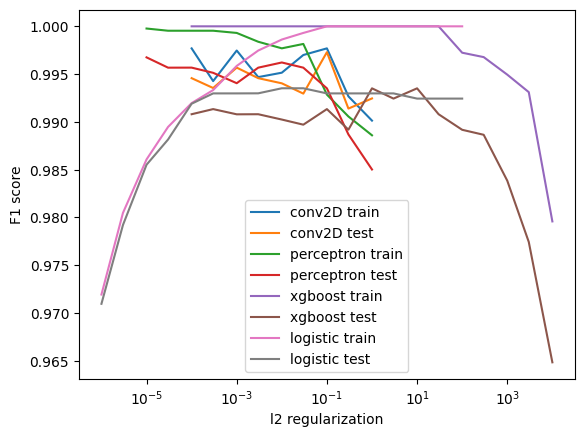

In [69]:
plt.plot(conv2d_stats[0],conv2d_stats[1],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[2],label='conv2D test')
plt.plot(per_stats[0],per_stats[1],label='perceptron train')
plt.plot(per_stats[0],per_stats[2],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[1],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[2],label='xgboost test')
plt.plot(stats_log[0],stats_log[1],label='logistic train')
plt.plot(stats_log[0],stats_log[2],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('F1 score')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(f1_score(target_train,l_train_pred),5)}")
print(f"Logistic test {np.round(f1_score(target_test,l_test_pred),5)}")
print(f"xgboost train {np.round(f1_score(target_train,train_pred),5)}")
print(f"xgboost test {np.round(f1_score(target_test,test_pred),5)}")
print(f"perceptron train {np.round(f1_score(target_train,np.round(m_train)),5)}")
print(f"perceptron test {np.round(f1_score(target_test,np.round(m_test)),5)}")
print(f"conv2d train {np.round(f1_score(target_train,np.round(c_train)),5)}")
print(f"conv2d test {np.round(f1_score(target_test,np.round(c_test)),5)}")
print("best regularized")
print(f"perceptron train {np.round(np.max(per_stats[1]),5)}")
print(f"perceptron test {np.round(np.max(per_stats[2]),5)}")
print(f"conv2d train {np.round(np.max(conv2d_stats[1]),5)}")
print(f"conv2d test {np.round(np.max(conv2d_stats[2]),5)}")
print(f"xgboost train {np.round(np.max(stats_xgb[1]),5)}")
print(f"xgboost test {np.round(np.max(stats_xgb[2]),5)}")
print(f"logistic train {np.round(np.max(stats_log[1]),5)}")
print(f"logistic test {np.round(np.max(stats_log[2]),5)}")

Is improved now in test for all besides xgboost. Best is convolutional network, then perceptron, then on the same level logistic and xgboost. There are so few wrong, that it can be partlz chnace. Log loss depends less on few, thus I also look on them. 

not regularized
Logistic train 0.0
Logistic test 0.39888
xgboost train 0.00124
xgboost test 0.03244
perceptron train 0.00064
perceptron test 0.03759
conv2d train 0.0
conv2d test 0.06244
best regularized
perceptron train 0.0009
perceptron test 0.04345
conv2d train 0.01237
conv2d test 0.02621
xgboost train 0.00099
xgboost test 0.02985
logistic train 1e-05
logistic test 0.0361


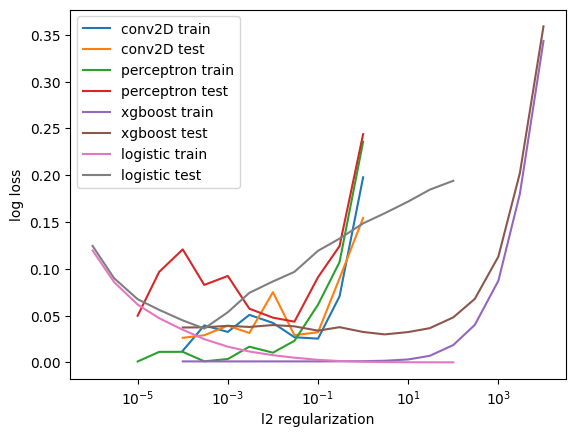

In [70]:
plt.plot(conv2d_stats[0],conv2d_stats[3],label='conv2D train')
plt.plot(conv2d_stats[0],conv2d_stats[4],label='conv2D test')
plt.plot(per_stats[0],per_stats[3],label='perceptron train')
plt.plot(per_stats[0],per_stats[4],label='perceptron test')
plt.plot(stats_xgb[0],stats_xgb[3],label='xgboost train')
plt.plot(stats_xgb[0],stats_xgb[4],label='xgboost test')
plt.plot(stats_log[0],stats_log[3],label='logistic train')
plt.plot(stats_log[0],stats_log[4],label='logistic test')
plt.legend(loc="best")
#plt.title('Loss vs Epochs')
plt.xlabel('l2 regularization')
plt.ylabel('log loss')
#plt.ylim(0,0.7)
plt.xscale("log")
print("not regularized")
print(f"Logistic train {np.round(log_loss(target_train,l_train_pred_prob),5)}")
print(f"Logistic test {np.round(log_loss(target_test,l_test_pred_prob),5)}")
print(f"xgboost train {np.round(log_loss(target_train,train_pred_prob),5)}")
print(f"xgboost test {np.round(log_loss(target_test,test_pred_prob),5)}")
print(f"perceptron train {np.round(log_loss(target_train,(m_train)),5)}")
print(f"perceptron test {np.round(log_loss(target_test,(m_test)),5)}")
print(f"conv2d train {np.round(log_loss(target_train,(c_train)),5)}")
print(f"conv2d test {np.round(log_loss(target_test,(c_test)),5)}")
print("best regularized")
print(f"perceptron train {np.round(np.min(per_stats[3]),5)}")
print(f"perceptron test {np.round(np.min(per_stats[4]),5)}")
print(f"conv2d train {np.round(np.min(conv2d_stats[3]),5)}")
print(f"conv2d test {np.round(np.min(conv2d_stats[4]),5)}")
print(f"xgboost train {np.round(np.min(stats_xgb[3]),5)}")
print(f"xgboost test {np.round(np.min(stats_xgb[4]),5)}")
print(f"logistic train {np.round(np.min(stats_log[3]),5)}")
print(f"logistic test {np.round(np.min(stats_log[4]),5)}")

Similar but not identical. Best in convoltional network, then xgboost, then logistic then perceptron, all are rather similar.

As the step I run the best of all four algorithm. I decide to use log loss as to find the best one. 


First printing the value, also for checking that it is not an isolated minimum. I ignore the minimum at low regularization of convolutional, since it seems unplausible.

In [74]:
best_reg_conv=conv2d_stats[0,int(np.argmin(conv2d_stats[4,2:])+2)]
print(f"best regularization of conv 2d is {best_reg_conv}")
best_reg_per=per_stats[0,(np.argmin(per_stats[4]))]
print(f"best regularization of perceptron is {best_reg_per}")
best_reg_xgb=stats_xgb[0,(np.argmin(stats_xgb[4]))]
print(f"best regularization of xgboost is {best_reg_xgb}")
best_reg_log=stats_log[0,(np.argmin(stats_log[4]))]
print(f"best regularization of logistic is {best_reg_log}")

best regularization of conv 2d is 0.03
best regularization of perceptron is 0.03
best regularization of xgboost is 3.0
best regularization of logistic is 0.0003


In [75]:
xc2=XGBClassifier(max_depth=6,reg_lambda=3.0).fit(feature_train,target_train)
x2_train_pred_prob=xc2.predict_proba(feature_train)
x2_test_pred_prob=xc2.predict_proba(feature_test)

In [76]:
lc2=LogisticRegression(penalty='l2',C=0.0003,max_iter=3000).fit(feature_train,target_train)
l2_train_pred_prob=lc2.predict_proba(feature_train)
l2_test_pred_prob=lc2.predict_proba(feature_test)

In [79]:
num_features=121
keep_prob=1
modelp =BinaryClassification3(num_features)            
modelp.to(device)
loss_stats_test3 = {
        'train': [], 'test': []
        }
torch_fit(modelp,train_loader,test_loader,200,64,0.001,loss_stats_test3,l2reg=0.03)
p2_test_pred=pred_torch(modelp,test_loader)
p2_train_pred=pred_torch(modelp,train_loader_pred)

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.49923 | Test Loss: 0.27995
Epoch 002: | Train Loss: 0.38243 | Test Loss: 0.19857
Epoch 003: | Train Loss: 0.33111 | Test Loss: 0.26404
Epoch 004: | Train Loss: 0.29114 | Test Loss: 0.25334
Epoch 005: | Train Loss: 0.29210 | Test Loss: 0.24956
Epoch 006: | Train Loss: 0.29814 | Test Loss: 0.32864
Epoch 007: | Train Loss: 0.21999 | Test Loss: 0.25003
Epoch 008: | Train Loss: 0.27612 | Test Loss: 0.17838
Epoch 009: | Train Loss: 0.27294 | Test Loss: 0.18212
Epoch 010: | Train Loss: 0.27355 | Test Loss: 0.18284
Epoch 011: | Train Loss: 0.27347 | Test Loss: 0.17774
Epoch 012: | Train Loss: 0.27351 | Test Loss: 0.26558
Epoch 013: | Train Loss: 0.29730 | Test Loss: 0.32505
Epoch 014: | Train Loss: 0.24611 | Test Loss: 0.35446
Epoch 015: | Train Loss: 0.17171 | Test Loss: 0.41527
Epoch 016: | Train Loss: 0.20388 | Test Loss: 0.24010
Epoch 017: | Train Loss: 0.19047 | Test Loss: 0.25675
Epoch 018: | Train Loss: 0.21710 | Test Loss: 0.14920
Epoch 019: | Train Loss: 0.1

Epoch 153: | Train Loss: 0.04268 | Test Loss: 0.08719
Epoch 154: | Train Loss: 0.11841 | Test Loss: 0.09140
Epoch 155: | Train Loss: 0.06411 | Test Loss: 0.09088
Epoch 156: | Train Loss: 0.04390 | Test Loss: 0.09046
Epoch 157: | Train Loss: 0.04364 | Test Loss: 0.08855
Epoch 158: | Train Loss: 0.04447 | Test Loss: 0.08800
Epoch 159: | Train Loss: 0.04570 | Test Loss: 0.09014
Epoch 160: | Train Loss: 0.04889 | Test Loss: 0.08111
Epoch 161: | Train Loss: 0.05141 | Test Loss: 0.09125
Epoch 162: | Train Loss: 0.04452 | Test Loss: 0.23448
Epoch 163: | Train Loss: 0.14475 | Test Loss: 0.39044
Epoch 164: | Train Loss: 0.08854 | Test Loss: 0.16698
Epoch 165: | Train Loss: 0.06439 | Test Loss: 0.16530
Epoch 166: | Train Loss: 0.05144 | Test Loss: 0.09913
Epoch 167: | Train Loss: 0.04446 | Test Loss: 0.09548
Epoch 168: | Train Loss: 0.04626 | Test Loss: 0.09010
Epoch 169: | Train Loss: 0.04472 | Test Loss: 0.08819
Epoch 170: | Train Loss: 0.04293 | Test Loss: 0.08854
Epoch 171: | Train Loss: 0.0

In [80]:
#slower than perceptron but not much 
keep_prob=1
modelc =CNNBinary3()            
modelc.to(device)
loss_stats_test_c = {
        'train': [], 'test': []
        }
torch_fit(modelc,train_im_loader,test_im_loader,200,64,0.001,loss_stats_test_c,l2reg=0.03)
c2_test_pred=pred_torch(modelc,test_im_loader)
c2_train_pred=pred_torch(modelc,train_im_loader_pred)

Begin training.


/tmp/ipykernel_4316/3977962575.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.fc1.weight)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 33.74343 | Test Loss: 34.37500
Epoch 002: | Train Loss: 33.91192 | Test Loss: 34.37501
Epoch 003: | Train Loss: 34.01097 | Test Loss: 34.37503
Epoch 004: | Train Loss: 16.11593 | Test Loss: 0.39845
Epoch 005: | Train Loss: 0.71862 | Test Loss: 0.19004
Epoch 006: | Train Loss: 0.88837 | Test Loss: 0.08141
Epoch 007: | Train Loss: 0.21111 | Test Loss: 0.04801
Epoch 008: | Train Loss: 0.16481 | Test Loss: 0.26538
Epoch 009: | Train Loss: 0.19472 | Test Loss: 0.18710
Epoch 010: | Train Loss: 0.08023 | Test Loss: 0.03007
Epoch 011: | Train Loss: 0.17758 | Test Loss: 0.18834
Epoch 012: | Train Loss: 0.10838 | Test Loss: 0.17263
Epoch 013: | Train Loss: 0.09778 | Test Loss: 0.17499
Epoch 014: | Train Loss: 0.08066 | Test Loss: 0.06798
Epoch 015: | Train Loss: 0.10691 | Test Loss: 0.02782
Epoch 016: | Train Loss: 0.07909 | Test Loss: 0.03410
Epoch 017: | Train Loss: 0.05249 | Test Loss: 0.10901
Epoch 018: | Train Loss: 0.07974 | Test Loss: 0.02593
Epoch 019: | Train Lo

Epoch 153: | Train Loss: 0.03663 | Test Loss: 0.01820
Epoch 154: | Train Loss: 0.01688 | Test Loss: 0.02232
Epoch 155: | Train Loss: 0.02189 | Test Loss: 0.08856
Epoch 156: | Train Loss: 0.01695 | Test Loss: 0.15953
Epoch 157: | Train Loss: 0.01559 | Test Loss: 0.16005
Epoch 158: | Train Loss: 0.01558 | Test Loss: 0.15861
Epoch 159: | Train Loss: 0.01677 | Test Loss: 0.09402
Epoch 160: | Train Loss: 0.01960 | Test Loss: 0.15912
Epoch 161: | Train Loss: 0.01729 | Test Loss: 0.08860
Epoch 162: | Train Loss: 0.01743 | Test Loss: 0.16105
Epoch 163: | Train Loss: 0.01562 | Test Loss: 0.23252
Epoch 164: | Train Loss: 0.01695 | Test Loss: 0.15811
Epoch 165: | Train Loss: 0.01588 | Test Loss: 0.09177
Epoch 166: | Train Loss: 0.01655 | Test Loss: 0.22978
Epoch 167: | Train Loss: 0.13458 | Test Loss: 0.03908
Epoch 168: | Train Loss: 0.02371 | Test Loss: 0.03121
Epoch 169: | Train Loss: 0.01856 | Test Loss: 0.02530
Epoch 170: | Train Loss: 0.01739 | Test Loss: 0.09572
Epoch 171: | Train Loss: 0.0

Looking on wrong classifications concentrating on the ones which are clealy wrong. 

In [130]:
c=0
for i in range(len(x2_test_pred_prob)):
    avg=(x2_test_pred_prob[i,1]+c2_test_pred[i]+p2_test_pred[i]+l2_test_pred_prob[i,1])/4
    p=np.array([l2_test_pred_prob[i,1],x2_test_pred_prob[i,1],p2_test_pred[i],c2_test_pred[i]])
    if abs(avg-target_test[i])>0.5:
        print(f"case {i} class is {df_test['class'].iat[i]} with p {np.round(p,3)}")
        print(f"Mag(model)-Mag(star)={np.round(df_test.modelMag_r.iat[i]-df_test.psfMag_r.iat[i],3)}")
        if df_test['class'].iat[i]=='GALAXY':
            print(f"redshift is {np.round(df_test.redshift.iat[i],4)}")
        else:
            print(f"velocity is {np.round(df_test.redshift.iat[i]*299792)}")
        c+=1
print(c)        
diff2=df2[df2['class']=='GALAXY'].modelMag_r-df2[df2['class']=='GALAXY'].psfMag_r
print(diff2.describe())

case 22 class is GALAXY with p [0.305 0.028 0.133 0.101]
Mag(model)-Mag(star)=-0.234
redshift is 0.4016
case 52 class is GALAXY with p [0.81  0.036 0.434 0.621]
Mag(model)-Mag(star)=-0.373
redshift is 0.8663
case 239 class is GALAXY with p [0.296 0.224 0.127 0.276]
Mag(model)-Mag(star)=-0.312
redshift is 0.1316
case 1091 class is STAR with p [0.279 0.999 0.539 0.917]
Mag(model)-Mag(star)=-0.038
velocity is 90.0
case 1092 class is GALAXY with p [0.006 0.277 0.007 0.948]
Mag(model)-Mag(star)=-0.294
redshift is 0.1381
case 1125 class is GALAXY with p [0.709 0.289 0.287 0.661]
Mag(model)-Mag(star)=-0.441
redshift is 0.2353
case 1131 class is STAR with p [1.    0.624 0.986 0.951]
Mag(model)-Mag(star)=-0.001
velocity is -26.0
case 1151 class is STAR with p [0.012 0.767 0.944 0.459]
Mag(model)-Mag(star)=-0.03
velocity is 70.0
case 1289 class is GALAXY with p [0.044 0.052 0.03  0.043]
Mag(model)-Mag(star)=-0.21
redshift is 0.5941
9
count    3092.000000
mean       -1.374348
std         0.633466

Looking on properties of table, I have not yet found something obvious which hints that classifications are faulty. The galaxies included here are more compact than most, that is expected that the galaxies with the problems are the smaller ones, but that is true for both wrong classifications in the labels and by the algorithms. They are not obvious outliers, see plot below. Likely the sample is too small to be able to distinguish the options. 

(0.1, -1.0)

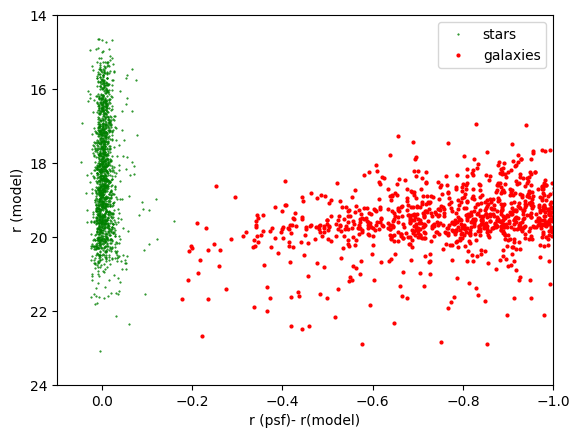

In [136]:
plt.plot(df2['modelMag_r'][df2['class']=='STAR']-df2['psfMag_r'][df2['class']=='STAR'],df2['modelMag_r'][df2['class']=='STAR'],'o',ms=0.5,color='green',label='stars')
plt.plot(df2['modelMag_r'][df2['class']=='GALAXY']-df2['psfMag_r'][df2['class']=='GALAXY'],df2['modelMag_r'][df2['class']=='GALAXY'],'o',ms=2,color='red',label='galaxies') 
plt.legend(loc="best")
plt.xlabel("r (psf)- r(model)")
plt.ylabel("r (model)")
plt.ylim(24,14)
plt.xlim(0.1,-1)
#plt.yscale("log")

Below I plot the images of the objects with classfications problems. 

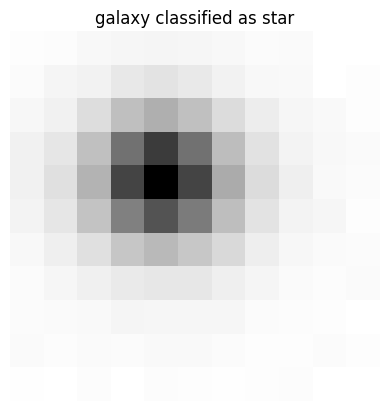

In [87]:
#all methods agree 
plt.axis('off')
plt.title("galaxy classified as star")
plt.imshow(-image_test[22,0,:,:].T,cmap=cm.gray, interpolation='nearest')

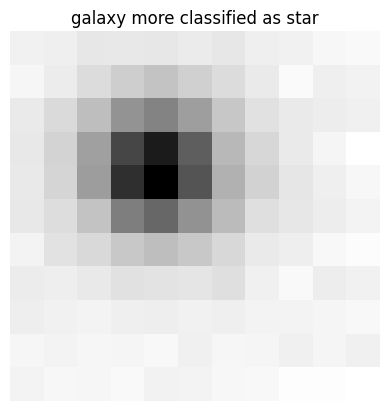

In [96]:
#logistic and convolutional are different
plt.axis('off')
plt.title("galaxy more classified as star")
plt.imshow(-image_test[52,0,:,:].T,cmap=cm.gray, interpolation='nearest')

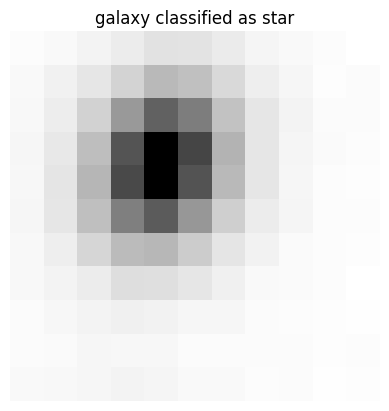

In [90]:
#all methods agree 
plt.axis('off')
plt.title("galaxy classified as star")
plt.imshow(-image_test[239,0,:,:].T,cmap=cm.gray, interpolation='nearest')

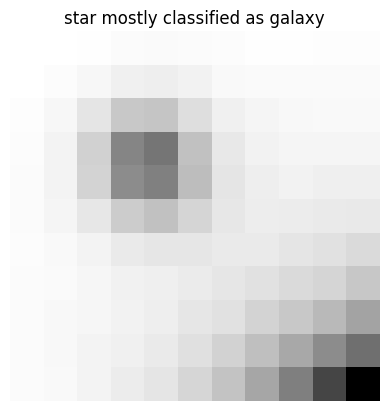

In [92]:
#logistic is different from other methods
plt.axis('off')
plt.title("star mostly classified as galaxy")
plt.imshow(-image_test[1091,0,:,:].T,cmap=cm.gray, interpolation='nearest')

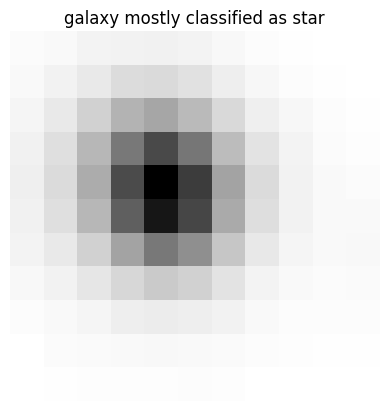

In [93]:
#convoltional is different from other methods
plt.axis('off')
plt.title("galaxy mostly classified as star")
plt.imshow(-image_test[1092,0,:,:].T,cmap=cm.gray, interpolation='nearest')

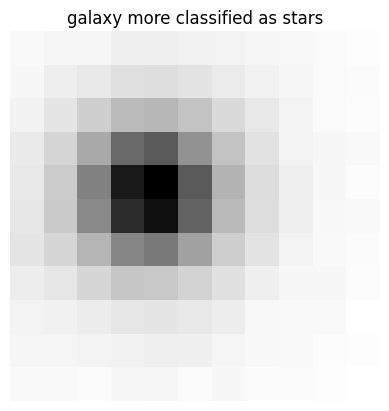

In [97]:
#logistic and convoltional disagree
plt.axis('off')
plt.title("galaxy more classified as stars")
plt.imshow(-image_test[1125,0,:,:].T,cmap=cm.gray, interpolation='nearest')

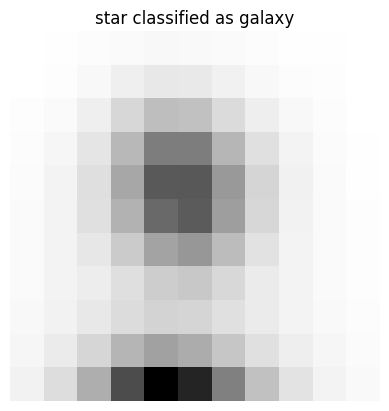

In [88]:
plt.axis('off')
plt.title("star classified as galaxy")
plt.imshow(-image_test[1131,0,:,:].T,cmap=cm.gray, interpolation='nearest')

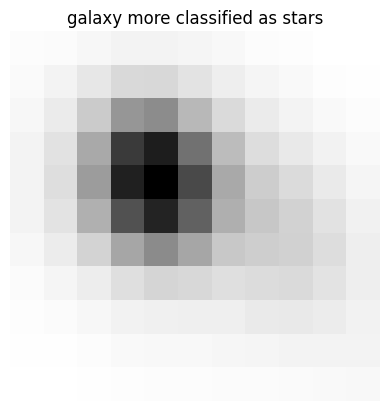

In [98]:
#logistic and convoltional disagree
plt.axis('off')
plt.title("galaxy more classified as star")
plt.imshow(-image_test[1151,0,:,:].T,cmap=cm.gray, interpolation='nearest')

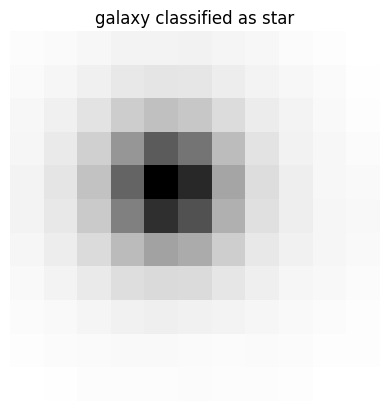

In [85]:
plt.axis('off')
plt.title("galaxy classified as star")
plt.imshow(-image_test[1289,0,:,:].T,cmap=cm.gray, interpolation='nearest')

The one above look rather normal compact, there few if at all obvious galaxies to the eye.
All of those look rather round per eye and when there are differences it is in the level of concentration. The human eye is not particularly good in finding that. Thus looking on the images does not help. Algorothm are better. 

The sample is possible too small to find the reason. I could also look on shape based parameters like moments later but also for that sample is likely too small currently. 